# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

!pip install gensim

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import GRU, Bidirectional

import nltk
from nltk.tokenize import word_tokenize
import string

import requests
import zipfile
import os

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read Dataset

In [ ]:
train_data = pd.read_csv('/kaggle/input/datasett/train_data.csv')
val_data = pd.read_csv('/kaggle/input/datasett/val_data.csv')
test_data = pd.read_csv('/kaggle/input/datasett/test_data.csv')

In [ ]:
train_data.head()

preprocessed_text  label
0  love job love kid time feel like person leave ...      0
1                  think girl feel way guy like tell      2
2                                     feel depressed      0
3      feel come assaulted wall wildly dynamic sound      4
4  feel throw away rotten vegetable double realiz...      0

In [ ]:
val_data.head()

preprocessed_text  label
0          struggle lot writer block feeling inspire      1
1                               want know feel needy      0
2  discover bloke life feel pretty pissed thou de...      3
3                            hope feel tomorrow well      1
4                                      feel honoured      1

In [ ]:
test_data.head()

preprocessed_text  label
0                      feel particularly neurotic      4
1  feel little overwhelmed think lot easy welding      4
2                        feel important influence      1
3                                     feel afraid      4
4                                     feel lonely      0

In [ ]:
train_data['label'].value_counts()

label
1    112620
0     96787
3     45781
4     38127
2     27598
5     11967
Name: count, dtype: int64

In [ ]:
val_data['label'].value_counts()

label
1    14078
0    12098
3     5722
4     4766
2     3450
5     1496
Name: count, dtype: int64

In [ ]:
test_data['label'].value_counts()

label
1    14078
0    12099
3     5723
4     4766
2     3449
5     1496
Name: count, dtype: int64

# GLOVE

**GloVe (Global Vectors for Word Representation)** adalah model pembelajaran vektor kata yang menggunakan statistik co-occurrence kata di seluruh korpus untuk menangkap hubungan semantik antar kata. Berbeda dengan **Word2Vec** yang fokus pada konteks lokal (window kata di sekitar), GloVe menggabungkan informasi global dari seluruh dokumen, sehingga memberikan representasi kata yang lebih stabil untuk analisis hubungan kata secara keseluruhan. Intinya, Word2Vec lebih fokus pada konteks langsung, sementara GloVe menggunakan pendekatan global.

In [ ]:
# URL GloVe yang ingin diunduh
url = 'http://nlp.stanford.edu/data/glove.6B.zip'

# Path untuk menyimpan file zip yang diunduh
zip_file = 'glove.6B.zip'
extract_folder = 'glove_embeddings'

# Fungsi untuk mengunduh file
def download_glove(url, zip_file):
    r = requests.get(url)
    with open(zip_file, 'wb') as f:
        f.write(r.content)

# Fungsi untuk mengekstrak file zip
def extract_zip(zip_file, extract_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

# Cek apakah file sudah ada, jika belum, unduh dan ekstrak
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

if not os.path.exists(os.path.join(extract_folder, 'glove.6B.50d.txt')):
    print("Downloading GloVe embeddings...")
    download_glove(url, zip_file)
    print("Extracting GloVe embeddings...")
    extract_zip(zip_file, extract_folder)
else:
    print("GloVe embeddings already exist.")

# Cek apakah file berhasil diunduh dan diekstrak
if os.path.exists(os.path.join(extract_folder, 'glove.6B.50d.txt')):
    print("GloVe embeddings are ready!")
else:
    print("There was an issue with downloading or extracting the GloVe embeddings.")

Extracting GloVe embeddings...
GloVe embeddings are ready!


Proses diatas mendownload dan mengekstrak GloVe embeddings dari URL jika file belum ada di folder tujuan. Setelah itu, file embeddings seperti **50d** siap digunakan untuk representasi kata pre-trained.

**50d** dipilih karena lebih ringan secara komputasi dibanding dimensi yang lebih tinggi seperti 100d atau 300d, tetapi tetap cukup untuk menangkap hubungan semantik dasar antar kata. Dimensi yang lebih besar bisa memberikan detail lebih, tapi akan lebih berat untuk diproses, sehingga 50d adalah kompromi yang efisien.

In [ ]:
# Fungsi untuk memuat GloVe embeddings ke dalam dictionary
def load_glove_embeddings(glove_file):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Fungsi untuk mengonversi token menjadi urutan vektor menggunakan GloVe embeddings
def get_glove_sequence(tokens, glove_embeddings, vector_size=50):
    sequence = []
    for token in tokens:
        if token in glove_embeddings:
            sequence.append(glove_embeddings[token])
        else:
            sequence.append(np.zeros(vector_size))  # Vektor nol jika kata tidak ada dalam embeddings
    return sequence

# GloVe embeddings file
glove_file = 'glove_embeddings/glove.6B.50d.txt'

# Memuat GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_file)
print(f"Loaded {len(glove_embeddings)} words from GloVe embeddings.")

Loaded 400000 words from GloVe embeddings.


Proses diatas memuat GloVe embeddings dari file ke dalam dictionary untuk merepresentasikan kata-kata sebagai vektor. Jika kata dari token tidak ada di embeddings, maka diganti dengan vektor nol, sehingga setiap teks dapat direpresentasikan sebagai urutan vektor untuk analisis lebih lanjut, dengan total 400.000 kata yang tersedia dalam dictionary untuk digunakan sebagai representasi vektor kata.

In [ ]:
train_data['tokens'] = train_data['preprocessed_text'].apply(lambda x: x.split())
val_data['tokens'] = val_data['preprocessed_text'].apply(lambda x: x.split())
test_data['tokens'] = test_data['preprocessed_text'].apply(lambda x: x.split())

In [ ]:
train_data['sequence'] = train_data['tokens'].apply(lambda x: get_glove_sequence(x, glove_embeddings))
val_data['sequence'] = val_data['tokens'].apply(lambda x: get_glove_sequence(x, glove_embeddings))
test_data['sequence'] = test_data['tokens'].apply(lambda x: get_glove_sequence(x, glove_embeddings))

Memproses teks pada **train_data**, **val_data**, dan **test_data** menjadi token (list kata) dan mengonversinya menjadi urutan vektor menggunakan **GloVe embeddings**. Hasilnya adalah kolom **sequence** yang berisi representasi vektor dari setiap teks untuk digunakan dalam model.

In [ ]:
X_train_glove = pad_sequences(train_data['sequence'], maxlen=66, padding='post', dtype='float32')
X_val_glove = pad_sequences(val_data['sequence'], maxlen=66, padding='post', dtype='float32')
X_test_glove = pad_sequences(test_data['sequence'], maxlen=66, padding='post', dtype='float32')

Kami menggunakan **maxlen=66** berdasarkan hasil EDA sebelumnya, yang menunjukkan bahwa teks terpanjang di dataset memiliki 66 kata. Dengan menetapkan panjang ini, semua teks dipadatkan (padding) menjadi panjang yang konsisten untuk memastikan model dapat memproses input dengan ukuran tetap.

In [ ]:
y_train = train_data['label']
y_val = val_data['label']
y_test = test_data['label']

In [ ]:
print(f"Shape of X_train: {X_train_glove.shape}")
print(f"Shape of X_val: {X_val_glove.shape}")
print(f"Shape of X_test: {X_test_glove.shape}")

Shape of X_train: (332880, 66, 50)
Shape of X_val: (41610, 66, 50)
Shape of X_test: (41611, 66, 50)


X_train: Sebanyak 332,880 sampel, dengan panjang teks 66 kata, dan tiap kata direpresentasikan oleh vektor dengan dimensi 50.
X_val: Sebanyak 41,610 sampel, dengan panjang dan dimensi yang sama.
X_test: Sebanyak 41,611 sampel, juga dengan panjang dan dimensi yang sama.
Ini memastikan bahwa semua data memiliki ukuran input yang konsisten untuk digunakan dalam model deep learning.

In [ ]:
input_dim=X_train_glove.shape[1]

`input_dim = X_train_glove.shape[1]` digunakan untuk menentukan panjang urutan input (sequence length), yaitu **66** berdasarkan hasil padding. Nilai ini memastikan model dapat menerima data dengan dimensi yang konsisten untuk setiap sampel.

In [ ]:
def create_gru_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim, 50)))
    model.add(layers.GRU(64, return_sequences=False))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def create_bigru_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim, 50)))
    model.add(Bidirectional(GRU(64, return_sequences=False)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def create_lstm_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim, 50)))
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def create_bilstm_model(input_dim, learning_rate=0.001):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim, 50)))
    model.add(Bidirectional(layers.LSTM(64, return_sequences=False)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, num_classes):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(num_classes)], yticklabels=[f'Class {i}' for i in range(num_classes)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [ ]:
def train_and_evaluate(input_dim, batch_size, learning_rate, epochs, X_train, y_train, X_val, y_val, X_test, y_test, model_type='gru'):
    # Select the model type
    if model_type == 'gru':
        model = create_gru_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'bigru':
        model = create_bigru_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'lstm':
        model = create_lstm_model(input_dim, learning_rate=learning_rate)
    elif model_type == 'bilstm':
        model = create_bilstm_model(input_dim, learning_rate=learning_rate)
    else:
        raise ValueError("Invalid model_type. Choose 'gru', 'bigru', 'lstm', or 'bilstm'.")

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Plot training history
    print("\nTraining History:\n")
    plot_training_history(history)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Classification report
    report = classification_report(y_test, y_pred_labels)

    print("\nClassification Report:\n")
    print(report)

    # Calculate AUC
    try:
        test_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test, num_classes=6), y_pred, multi_class='ovr')
    except ValueError:
        test_auc = "AUC not available for fewer than two classes"

    # Metrics
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    precision = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['recall']
    f1_score = classification_report(y_test, y_pred_labels, output_dict=True)['weighted avg']['f1-score']

    metrics = {
        'Train Loss': train_loss,
        'Val Loss': val_loss,
        'Test Loss': test_loss,
        'AUC': test_auc,
        'Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score
    }

    # Print metrics
    print("\nMetrics:\n")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    print("")

    # Plot confusion matrix
    plot_confusion_matrix(model, X_test, y_test, num_classes=6)

    return model, metrics, history

## GRU

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 196s 5ms/step - accuracy: 0.3340 - loss: 1.5816 - val_accuracy: 0.3383 - val_loss: 1.5740
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 192s 5ms/step - accuracy: 0.3345 - loss: 1.5757 - val_accuracy: 0.3383 - val_loss: 1.5786
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 193s 5ms/step - accuracy: 0.3349 - loss: 1.5758 - val_accuracy: 0.3383 - val_loss: 1.5736
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 192s 5ms/step - accuracy: 0.3373 - loss: 1.5720 - val_accuracy: 0.3383 - val_loss: 1.5745
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 191s 5ms/step - accuracy: 0.3367 - loss: 1.5723 - val_accuracy: 0.3383 - val_loss: 1.5748
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 193s 5ms/step - accuracy: 0.3368 - loss: 1.5759 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/step - accuracy: 0.3374 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5746
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 192s 5ms/s

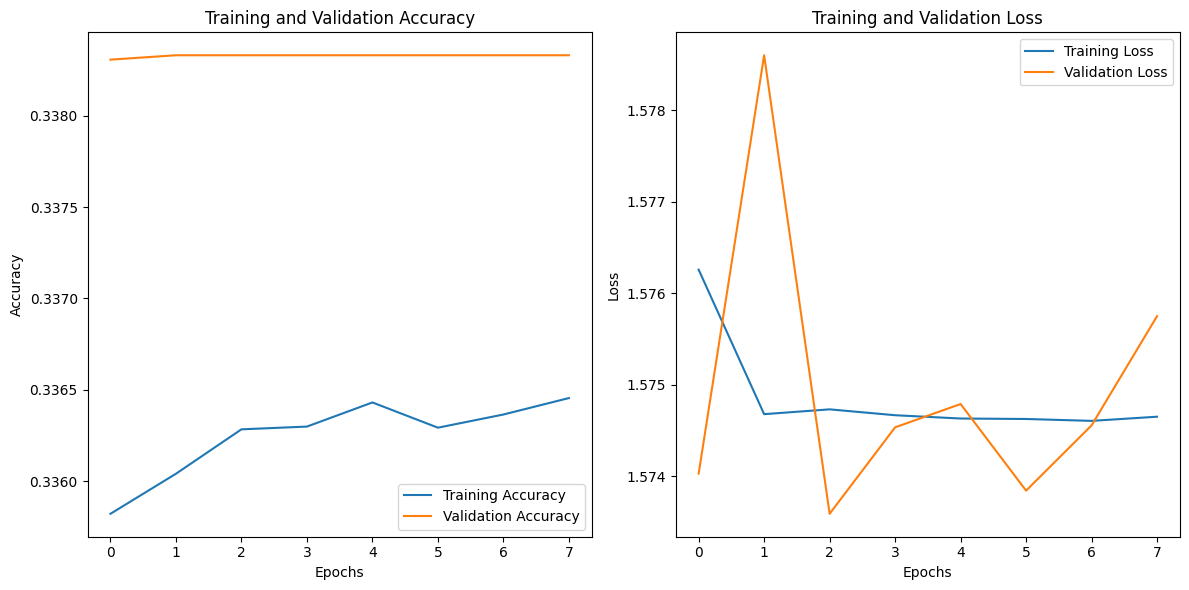

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5746527910232544
Val Loss: 1.5757521390914917
Test Loss: 1.5735703706741333
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


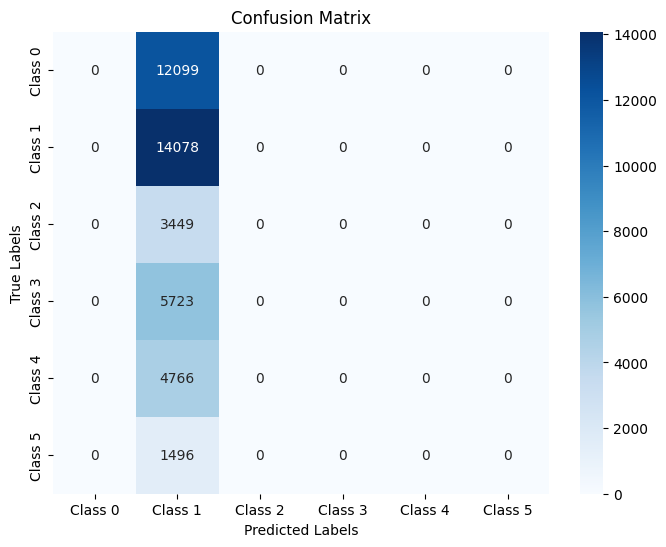


Model saved as 'glove_gru_model_1.h5'



In [ ]:
glove_gru_model_1, glove_gru_metrics_1, glove_gru_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_1.save('glove_gru_model_1.h5')
print("\nModel saved as 'glove_gru_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 197s 5ms/step - accuracy: 0.3341 - loss: 1.5788 - val_accuracy: 0.3383 - val_loss: 1.5734
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/step - accuracy: 0.3373 - loss: 1.5736 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/step - accuracy: 0.3386 - loss: 1.5719 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/step - accuracy: 0.3400 - loss: 1.5723 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - accuracy: 0.3375 - loss: 1.5752 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/step - accuracy: 0.3372 - loss: 1.5737 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 194s 5ms/step - accuracy: 0.3383 - loss: 1.5734 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 7: early stopping
Restoring model weights from th

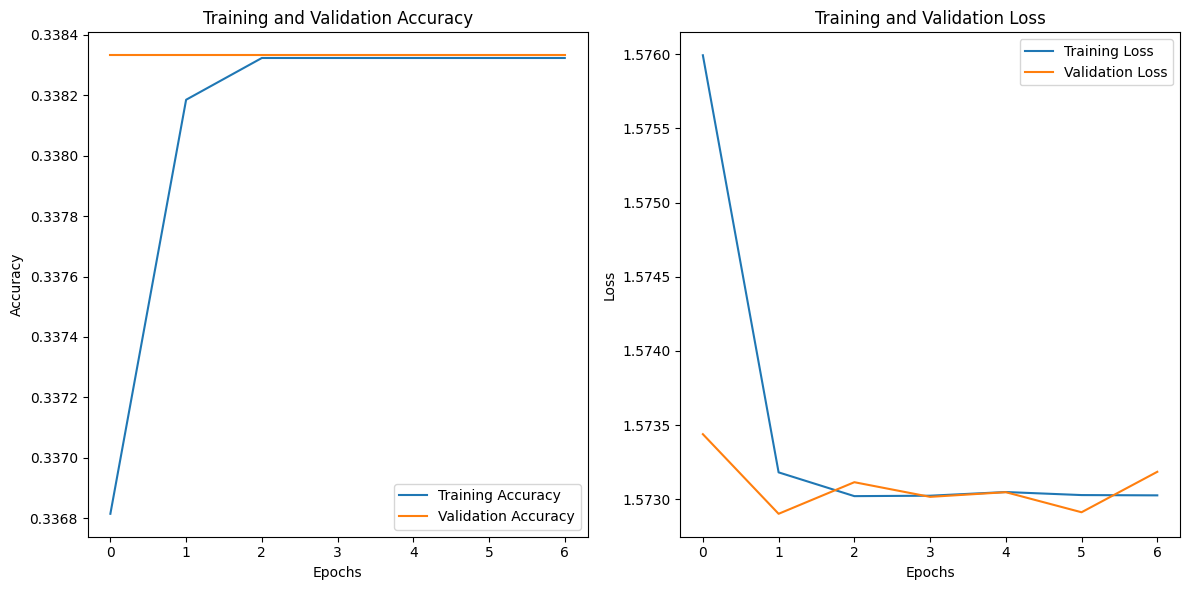

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5730262994766235
Val Loss: 1.5731850862503052
Test Loss: 1.572883129119873
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


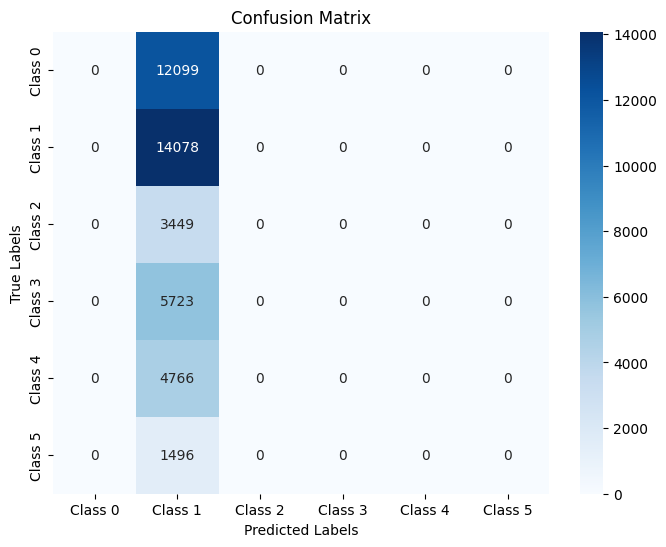


Model saved as 'glove_gru_model_2.h5'



In [ ]:
glove_gru_model_2, glove_gru_metrics_2, glove_gru_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_2.save('glove_gru_model_2.h5')
print("\nModel saved as 'glove_gru_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 195s 5ms/step - accuracy: 0.4646 - loss: 1.3629 - val_accuracy: 0.6424 - val_loss: 0.9570
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 193s 5ms/step - accuracy: 0.6618 - loss: 0.9144 - val_accuracy: 0.7539 - val_loss: 0.7106
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 193s 5ms/step - accuracy: 0.7651 - loss: 0.6836 - val_accuracy: 0.8224 - val_loss: 0.5068
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 192s 5ms/step - accuracy: 0.8300 - loss: 0.4943 - val_accuracy: 0.8507 - val_loss: 0.4085
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 193s 5ms/step - accuracy: 0.8579 - loss: 0.3964 - val_accuracy: 0.8696 - val_loss: 0.3483
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 192s 5ms/step - accuracy: 0.8738 - loss: 0.3392 - val_accuracy: 0.8809 - val_loss: 0.3051
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 193s 5ms/step - accuracy: 0.8830 - loss: 0.3045 - val_accuracy: 0.8901 - val_loss: 0.2703
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 192s 5ms/s

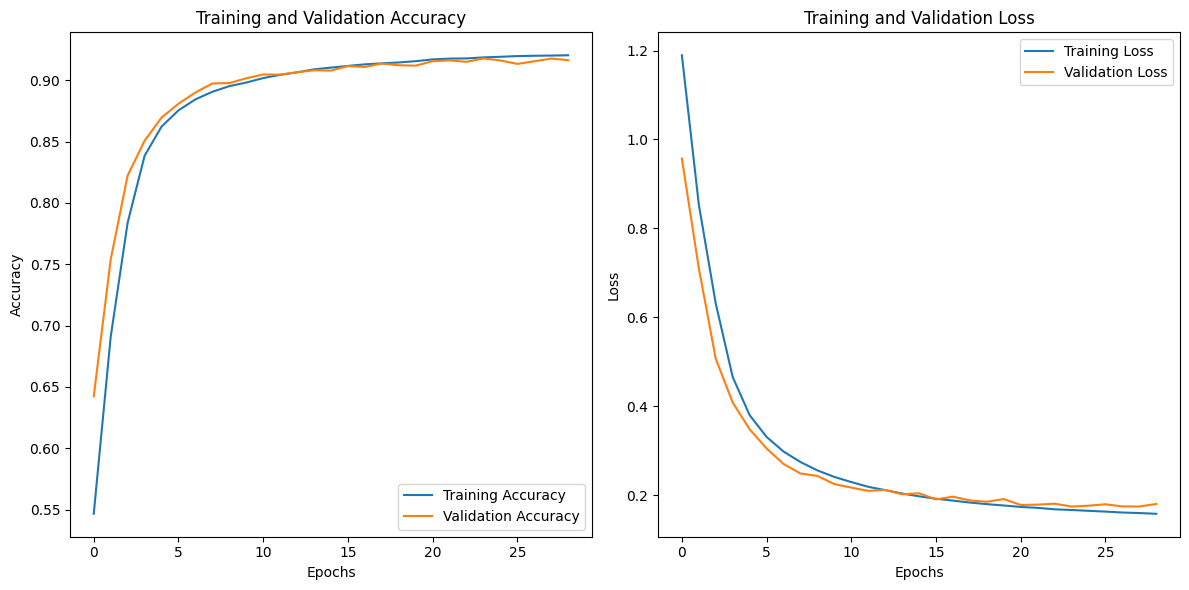

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12099
           1       0.93      0.94      0.93     14078
           2       0.80      0.79      0.79      3449
           3       0.92      0.93      0.92      5723
           4       0.85      0.92      0.88      4766
           5       0.88      0.68      0.76      1496

    accuracy                           0.91     41611
   macro avg       0.89      0.87      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.158199280500412
Val Loss: 0.18030516803264618
Test Loss: 0.18184344470500946
AUC: 0.9949927119435619
Accuracy: 0.9138208627700806
Precision: 0.9141216000917642
Recall: 0.9138208646752061
F1-Score: 0.9132945900500882

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


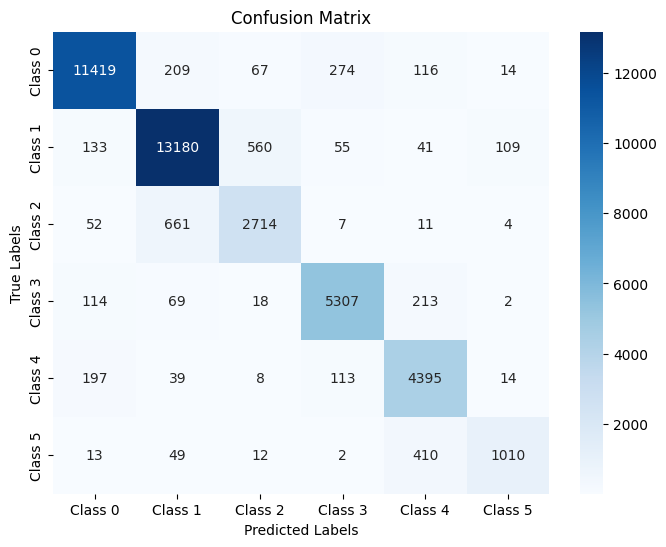


Model saved as 'glove_gru_model_3.h5'



In [ ]:
glove_gru_model_3, glove_gru_metrics_3, glove_gru_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_3.save('glove_gru_model_3.h5')
print("\nModel saved as 'glove_gru_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.3359 - loss: 1.5761 - val_accuracy: 0.3383 - val_loss: 1.5737
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - accuracy: 0.3385 - loss: 1.5729 - val_accuracy: 0.3383 - val_loss: 1.5747
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - accuracy: 0.3375 - loss: 1.5747 - val_accuracy: 0.3383 - val_loss: 1.5736
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - accuracy: 0.3369 - loss: 1.5739 - val_accuracy: 0.3384 - val_loss: 1.5758
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - accuracy: 0.3366 - loss: 1.5988 - val_accuracy: 0.3383 - val_loss: 1.5737
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - accuracy: 0.3388 - loss: 1.5742 - val_accuracy: 0.3383 - val_loss: 1.5742
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 96s 5ms/step - accuracy: 0.3372 - loss: 1.5727 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 97s 5ms/step - a

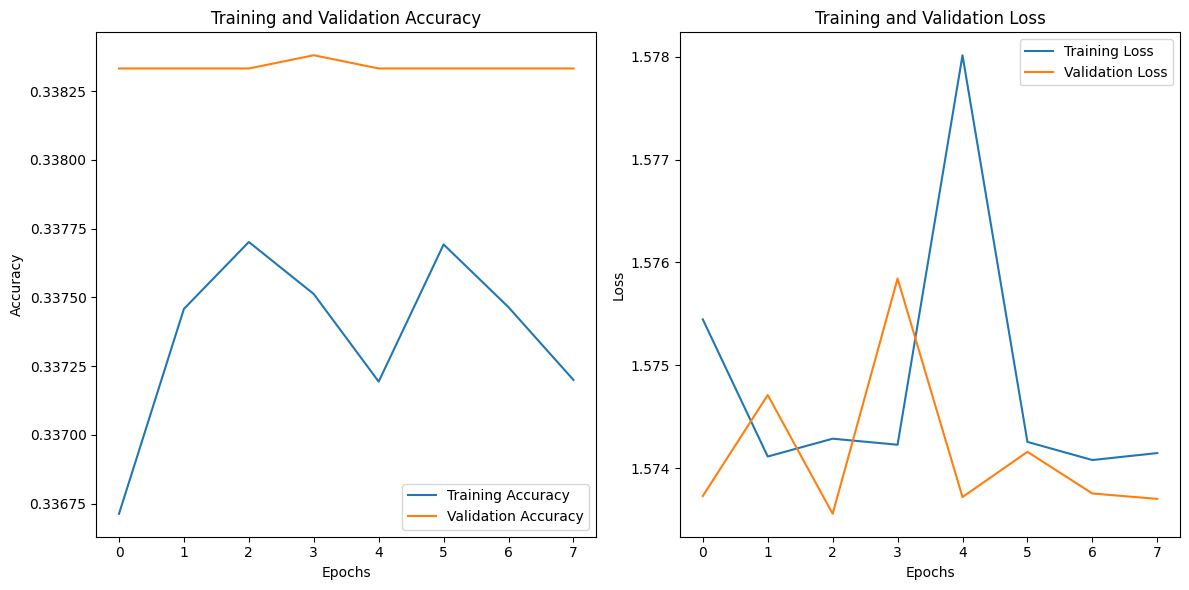

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.574147343635559
Val Loss: 1.5737019777297974
Test Loss: 1.5735365152359009
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


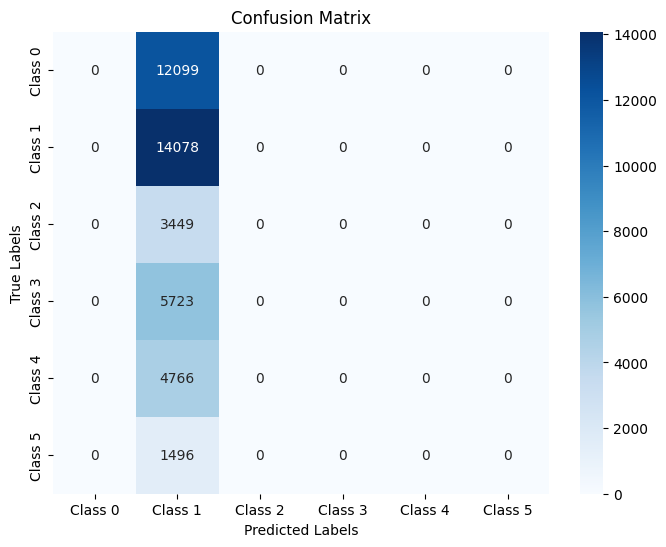


Model saved as 'glove_gru_model_4.h5'



In [ ]:
glove_gru_model_4, glove_gru_metrics_4, glove_gru_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_4.save('glove_gru_model_4.h5')
print("\nModel saved as 'glove_gru_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - accuracy: 0.3333 - loss: 1.5802 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3388 - loss: 1.5741 - val_accuracy: 0.3383 - val_loss: 1.5734
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3387 - loss: 1.5726 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3389 - loss: 1.5736 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3384 - loss: 1.5720 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3380 - loss: 1.5730 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - accuracy: 0.3386 - loss: 1.5725 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step - a

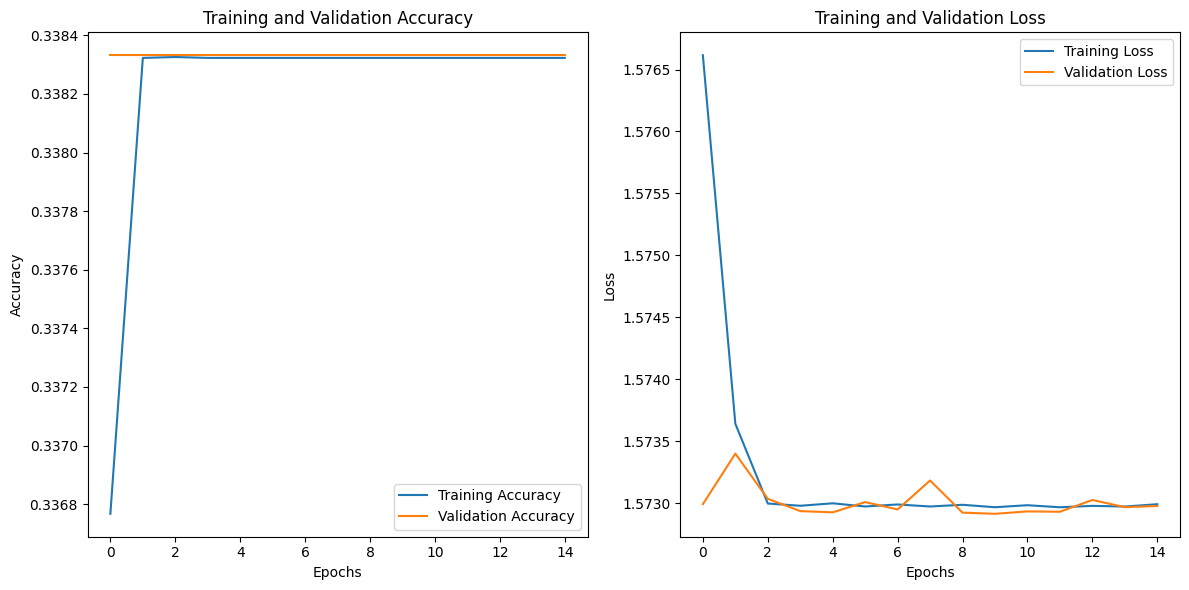

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5729913711547852
Val Loss: 1.572977066040039
Test Loss: 1.5728954076766968
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


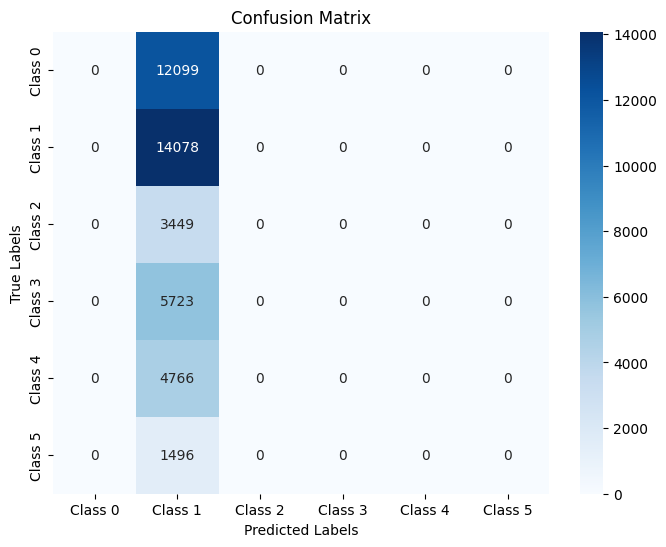


Model saved as 'glove_gru_model_5.h5'



In [ ]:
glove_gru_model_5, glove_gru_metrics_5, glove_gru_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_5.save('glove_gru_model_5.h5')
print("\nModel saved as 'glove_gru_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - accuracy: 0.4460 - loss: 1.4097 - val_accuracy: 0.6032 - val_loss: 1.0481
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.6231 - loss: 0.9999 - val_accuracy: 0.7087 - val_loss: 0.8027
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.7325 - loss: 0.7596 - val_accuracy: 0.7802 - val_loss: 0.6290
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.7921 - loss: 0.6137 - val_accuracy: 0.8109 - val_loss: 0.5310
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.8241 - loss: 0.5072 - val_accuracy: 0.8474 - val_loss: 0.4236
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.8469 - loss: 0.4341 - val_accuracy: 0.8602 - val_loss: 0.3746
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.8632 - loss: 0.3825 - val_accuracy: 0.8740 - val_loss: 0.3336
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step

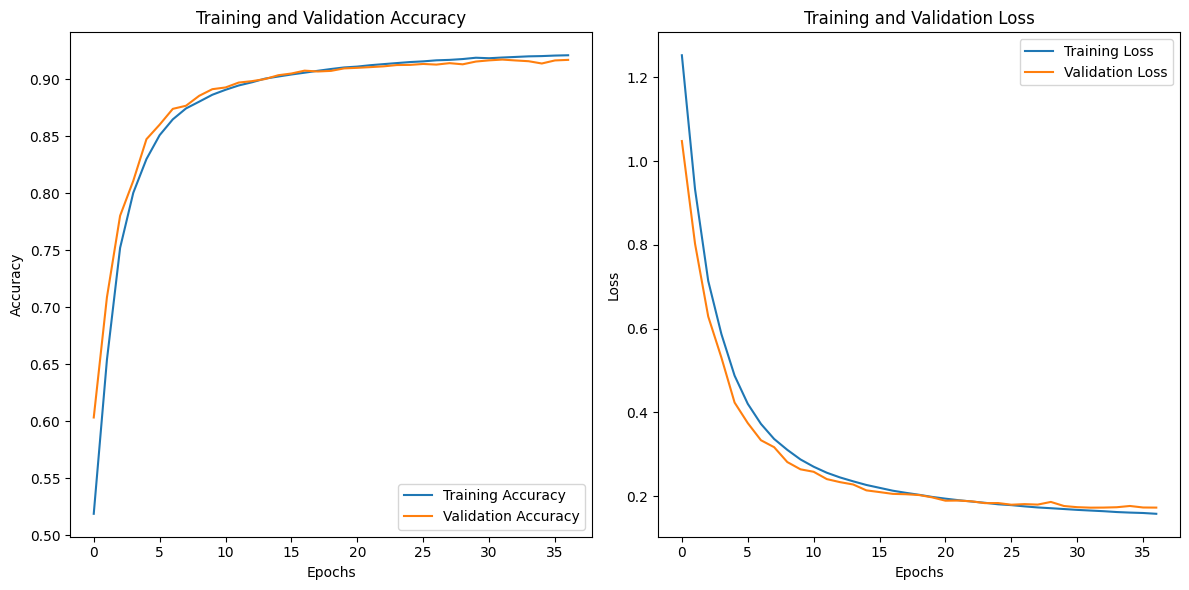

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12099
           1       0.93      0.94      0.93     14078
           2       0.82      0.77      0.79      3449
           3       0.89      0.96      0.92      5723
           4       0.88      0.89      0.88      4766
           5       0.81      0.76      0.78      1496

    accuracy                           0.91     41611
   macro avg       0.88      0.87      0.88     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.15794424712657928
Val Loss: 0.1727299690246582
Test Loss: 0.17923566699028015
AUC: 0.9950624989228437
Accuracy: 0.913460373878479
Precision: 0.9133479289580536
Recall: 0.9134603830717839
F1-Score: 0.9130777174589982

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


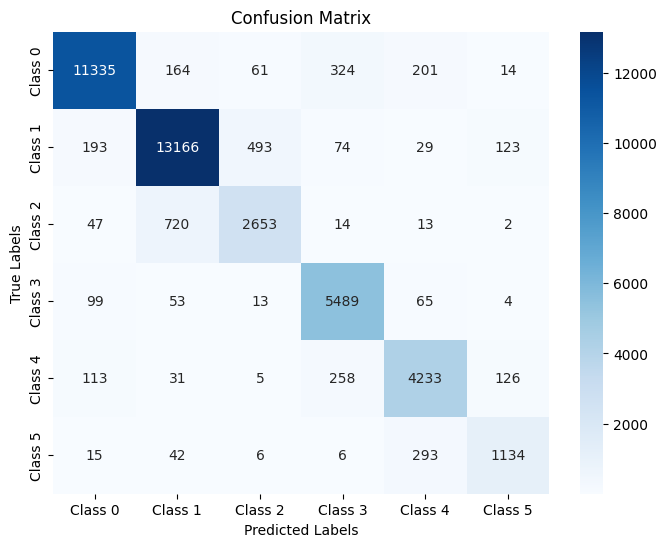


Model saved as 'glove_gru_model_6.h5'



In [ ]:
glove_gru_model_6, glove_gru_metrics_6, glove_gru_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_6.save('glove_gru_model_6.h5')
print("\nModel saved as 'glove_gru_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - accuracy: 0.3342 - loss: 1.5778 - val_accuracy: 0.3383 - val_loss: 1.5748
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3382 - loss: 1.5745 - val_accuracy: 0.3383 - val_loss: 1.5744
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3388 - loss: 1.5724 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3385 - loss: 1.5743 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3387 - loss: 1.5738 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3379 - loss: 1.5723 - val_accuracy: 0.3383 - val_loss: 1.5737
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3372 - loss: 1.5735 - val_accuracy: 0.3383 - val_loss: 1.5740
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - ac

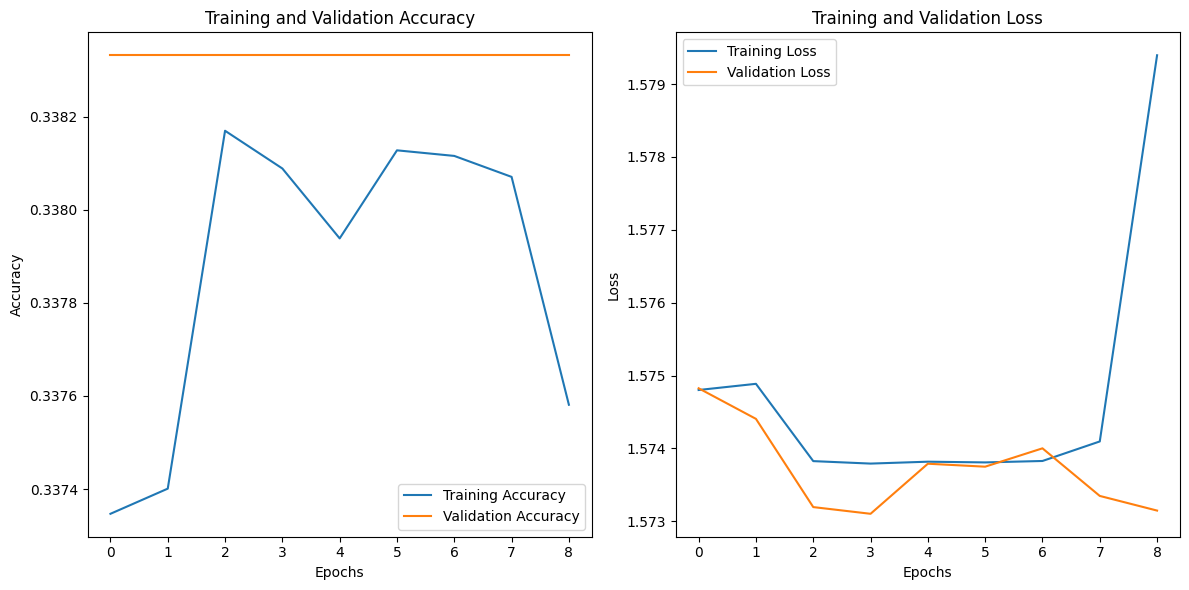

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5793949365615845
Val Loss: 1.5731474161148071
Test Loss: 1.5730822086334229
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


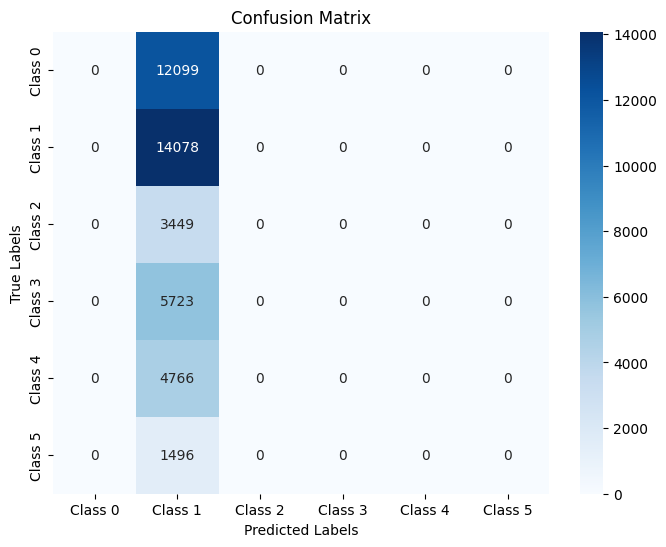


Model saved as 'glove_gru_model_7.h5'



In [ ]:
glove_gru_model_7, glove_gru_metrics_7, glove_gru_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_7.save('glove_gru_model_7.h5')
print("\nModel saved as 'glove_gru_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.3364 - loss: 1.5801 - val_accuracy: 0.3383 - val_loss: 1.5733
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3387 - loss: 1.5726 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3391 - loss: 1.5747 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3382 - loss: 1.5732 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3376 - loss: 1.5737 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3379 - loss: 1.5725 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3382 - loss: 1.5728 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 7: early stopping
Restoring model weights from the end o

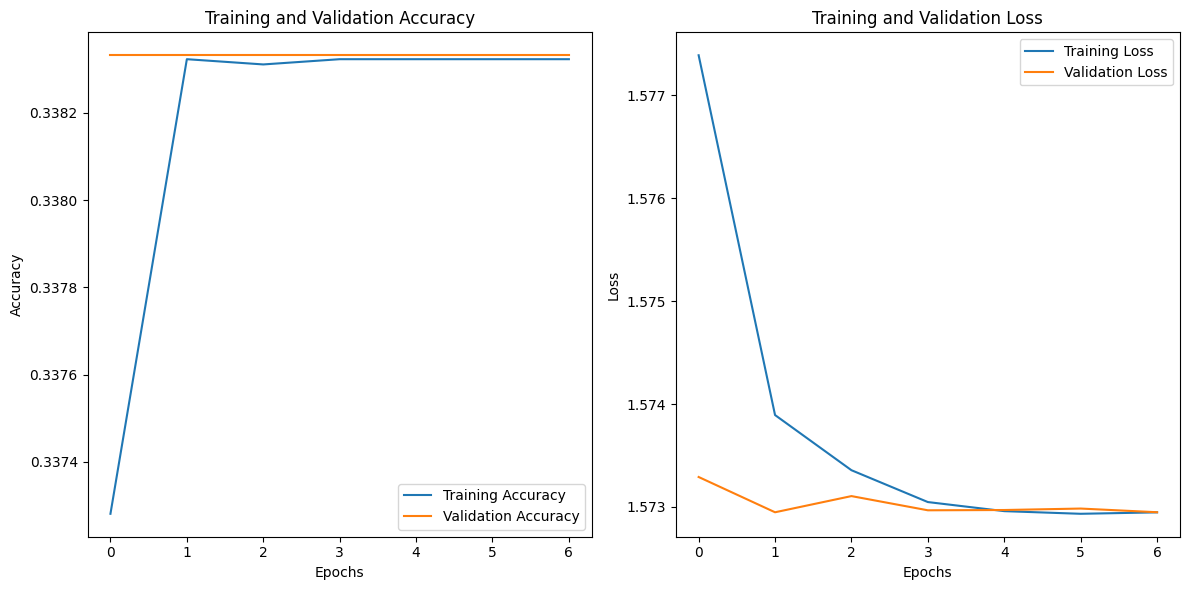

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5729477405548096
Val Loss: 1.572948932647705
Test Loss: 1.5729283094406128
AUC: 0.4993889548231252
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


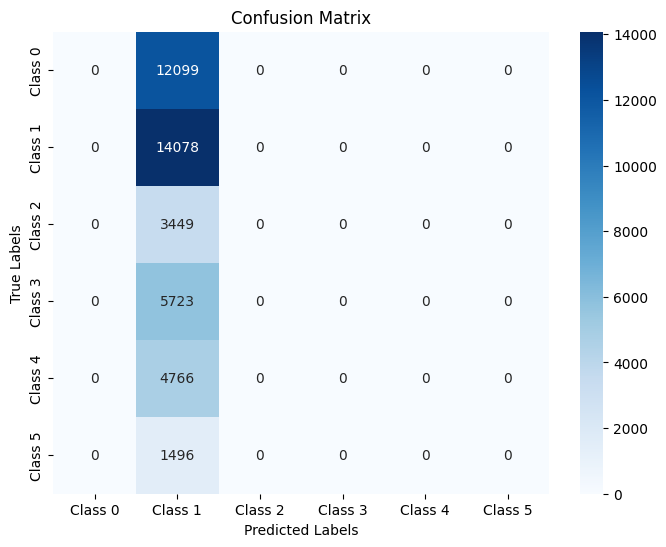


Model saved as 'glove_gru_model_8.h5'



In [ ]:
glove_gru_model_8, glove_gru_metrics_8, glove_gru_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_8.save('glove_gru_model_8.h5')
print("\nModel saved as 'glove_gru_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 58s 5ms/step - accuracy: 0.3895 - loss: 1.5070 - val_accuracy: 0.5619 - val_loss: 1.1477
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.5680 - loss: 1.1204 - val_accuracy: 0.6453 - val_loss: 0.9298
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.6644 - loss: 0.8975 - val_accuracy: 0.7409 - val_loss: 0.7073
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.7565 - loss: 0.6880 - val_accuracy: 0.8038 - val_loss: 0.5585
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.8034 - loss: 0.5649 - val_accuracy: 0.8336 - val_loss: 0.4730
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.8297 - loss: 0.4918 - val_accuracy: 0.8432 - val_loss: 0.4417
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.8447 - loss: 0.4479 - val_accuracy: 0.8549 - val_loss: 0.4000
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - ac

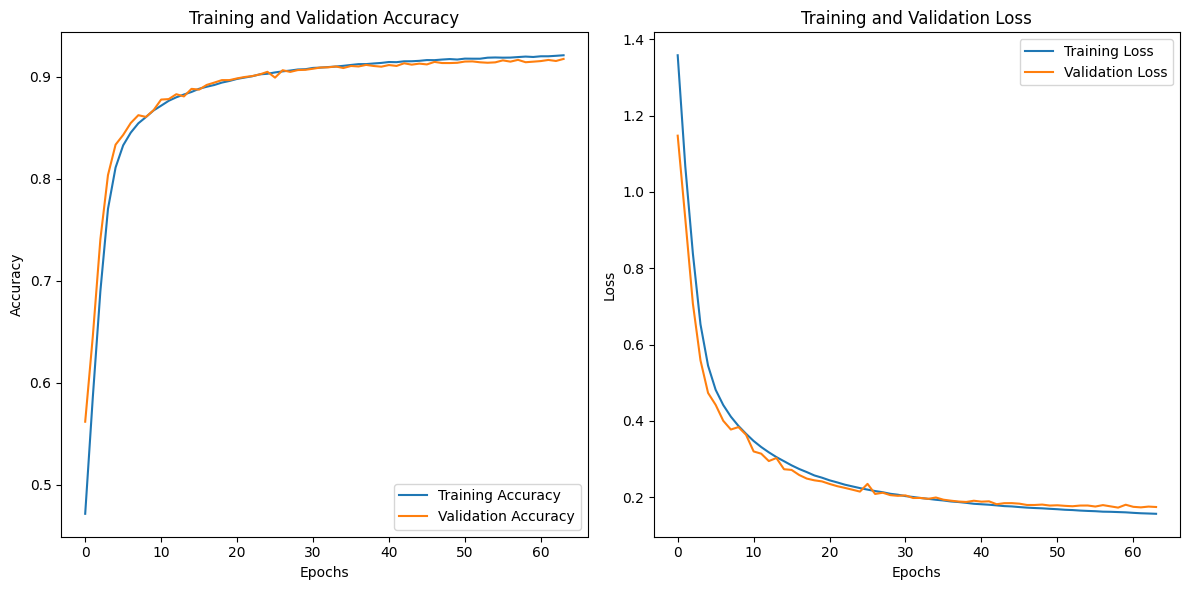

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12099
           1       0.96      0.90      0.93     14078
           2       0.75      0.91      0.82      3449
           3       0.91      0.92      0.91      5723
           4       0.88      0.88      0.88      4766
           5       0.74      0.89      0.81      1496

    accuracy                           0.91     41611
   macro avg       0.87      0.91      0.88     41611
weighted avg       0.92      0.91      0.91     41611


Metrics:

Train Loss: 0.15610428154468536
Val Loss: 0.1739126294851303
Test Loss: 0.17898015677928925
AUC: 0.9950778182735348
Accuracy: 0.9128836393356323
Precision: 0.9182071376638633
Recall: 0.9128836125063085
F1-Score: 0.9142829405614278

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


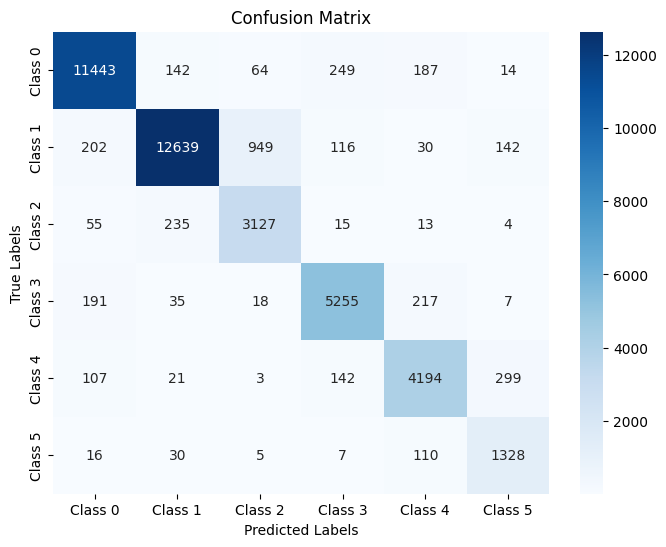


Model saved as 'glove_gru_model_9.h5'



In [ ]:
glove_gru_model_9, glove_gru_metrics_9, glove_gru_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="gru"
)

glove_gru_model_9.save('glove_gru_model_9.h5')
print("\nModel saved as 'glove_gru_model_9.h5'\n")

## Bi-GRU

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 303s 7ms/step - accuracy: 0.6768 - loss: 0.9423 - val_accuracy: 0.7946 - val_loss: 0.6324
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 300s 7ms/step - accuracy: 0.7204 - loss: 0.8351 - val_accuracy: 0.7850 - val_loss: 0.6567
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 299s 7ms/step - accuracy: 0.7204 - loss: 0.8335 - val_accuracy: 0.7563 - val_loss: 0.7002
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 299s 7ms/step - accuracy: 0.7144 - loss: 0.8437 - val_accuracy: 0.7711 - val_loss: 0.6840
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 300s 7ms/step - accuracy: 0.7123 - loss: 0.8523 - val_accuracy: 0.7878 - val_loss: 0.6359
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 300s 7ms/step - accuracy: 0.7145 - loss: 0.8473 - val_accuracy: 0.7822 - val_loss: 0.6233
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 301s 7ms/step - accuracy: 0.7187 - loss: 0.8300 - val_accuracy: 0.8020 - val_loss: 0.6212
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 301s 7ms/s

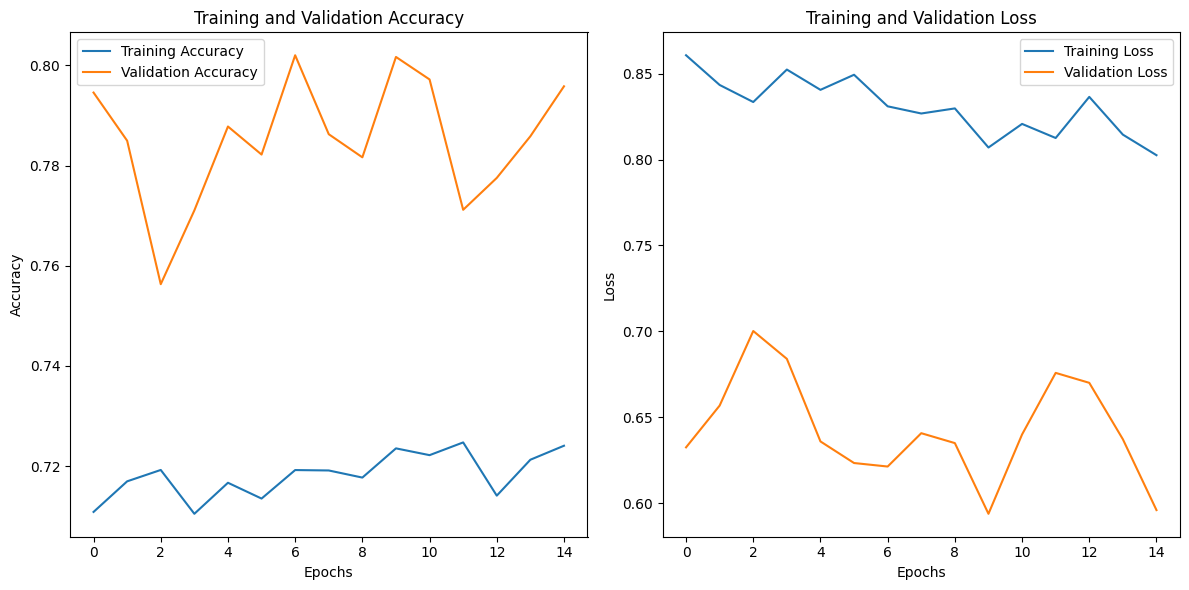

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86     12099
           1       0.70      0.95      0.80     14078
           2       0.88      0.41      0.56      3449
           3       0.93      0.73      0.82      5723
           4       0.84      0.73      0.78      4766
           5       0.89      0.55      0.68      1496

    accuracy                           0.80     41611
   macro avg       0.85      0.70      0.75     41611
weighted avg       0.82      0.80      0.80     41611


Metrics:

Train Loss: 0.802577018737793
Val Loss: 0.5958690643310547
Test Loss: 0.5922528505325317
AUC: 0.9633684573599551
Accuracy: 0.8011823892593384
Precision: 0.8235533155730982
Recall: 0.8011823796592247
F1-Score: 0.7955676233432255

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


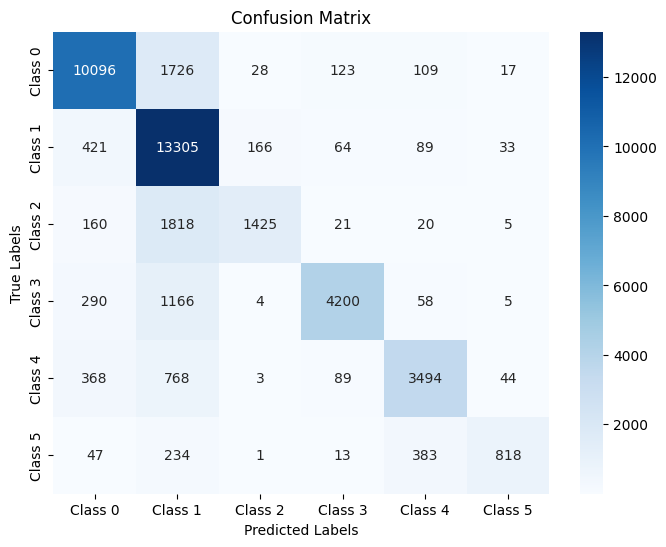


Model saved as 'glove_bigru_model_1.h5'



In [ ]:
glove_bigru_model_1, glove_bigru_metrics_1, glove_bigru_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_1.save('glove_bigru_model_1.h5')
print("\nModel saved as 'glove_bigru_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.7655 - loss: 0.6357 - val_accuracy: 0.8953 - val_loss: 0.2439
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 302s 7ms/step - accuracy: 0.8920 - loss: 0.2621 - val_accuracy: 0.9042 - val_loss: 0.2166
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 303s 7ms/step - accuracy: 0.9010 - loss: 0.2295 - val_accuracy: 0.9074 - val_loss: 0.2052
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 303s 7ms/step - accuracy: 0.9069 - loss: 0.2131 - val_accuracy: 0.9080 - val_loss: 0.2031
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 303s 7ms/step - accuracy: 0.9089 - loss: 0.2055 - val_accuracy: 0.9087 - val_loss: 0.2062
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 303s 7ms/step - accuracy: 0.9099 - loss: 0.1998 - val_accuracy: 0.9117 - val_loss: 0.2020
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.9114 - loss: 0.1978 - val_accuracy: 0.9113 - val_loss: 0.2042
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 303s 7ms/s

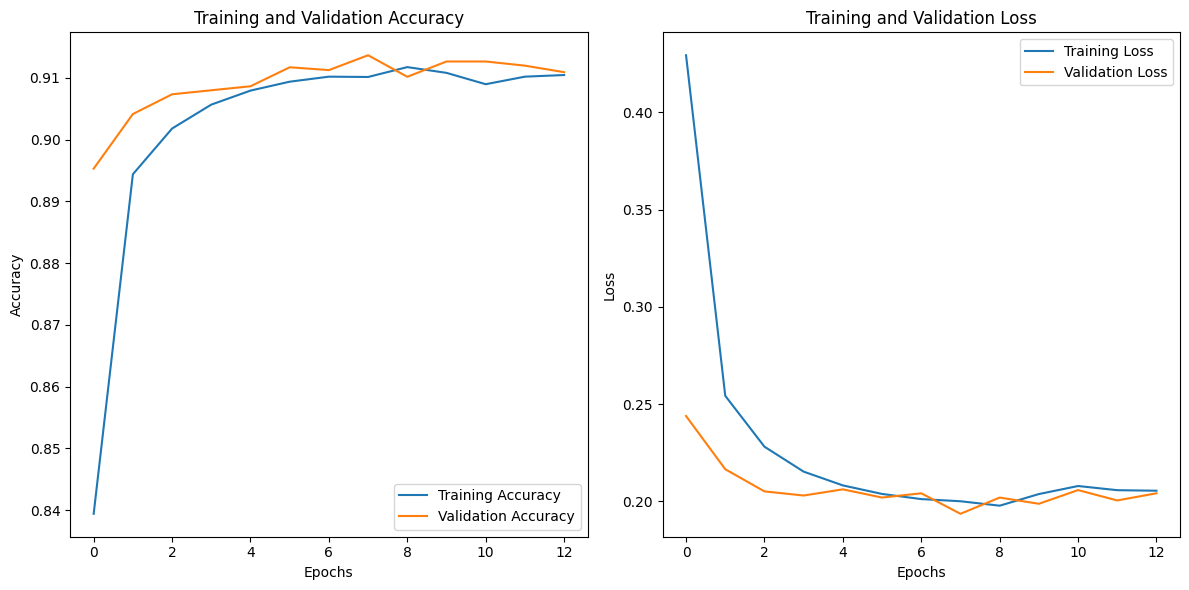

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     12099
           1       0.94      0.92      0.93     14078
           2       0.78      0.85      0.81      3449
           3       0.91      0.93      0.92      5723
           4       0.84      0.93      0.88      4766
           5       0.92      0.62      0.74      1496

    accuracy                           0.91     41611
   macro avg       0.89      0.87      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.20551730692386627
Val Loss: 0.20420308411121368
Test Loss: 0.19602246582508087
AUC: 0.9946054091423574
Accuracy: 0.9117060303688049
Precision: 0.9142725778031395
Recall: 0.9117060392684627
F1-Score: 0.9114205248531415

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


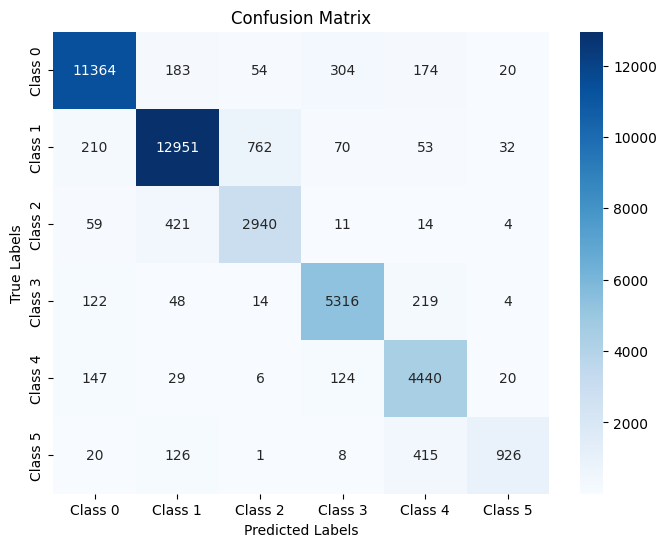


Model saved as 'glove_bigru_model_2.h5'



In [ ]:
glove_bigru_model_2, glove_bigru_metrics_2, glove_bigru_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_2.save('glove_bigru_model_2.h5')
print("\nModel saved as 'glove_bigru_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.5699 - loss: 1.1437 - val_accuracy: 0.8028 - val_loss: 0.5545
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 302s 7ms/step - accuracy: 0.8113 - loss: 0.5350 - val_accuracy: 0.8562 - val_loss: 0.3930
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 302s 7ms/step - accuracy: 0.8559 - loss: 0.3974 - val_accuracy: 0.8749 - val_loss: 0.3244
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 302s 7ms/step - accuracy: 0.8738 - loss: 0.3351 - val_accuracy: 0.8843 - val_loss: 0.2899
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 303s 7ms/step - accuracy: 0.8832 - loss: 0.2970 - val_accuracy: 0.8889 - val_loss: 0.2713
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.8902 - loss: 0.2740 - val_accuracy: 0.8941 - val_loss: 0.2491
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.8946 - loss: 0.2546 - val_accuracy: 0.8968 - val_loss: 0.2423
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/s

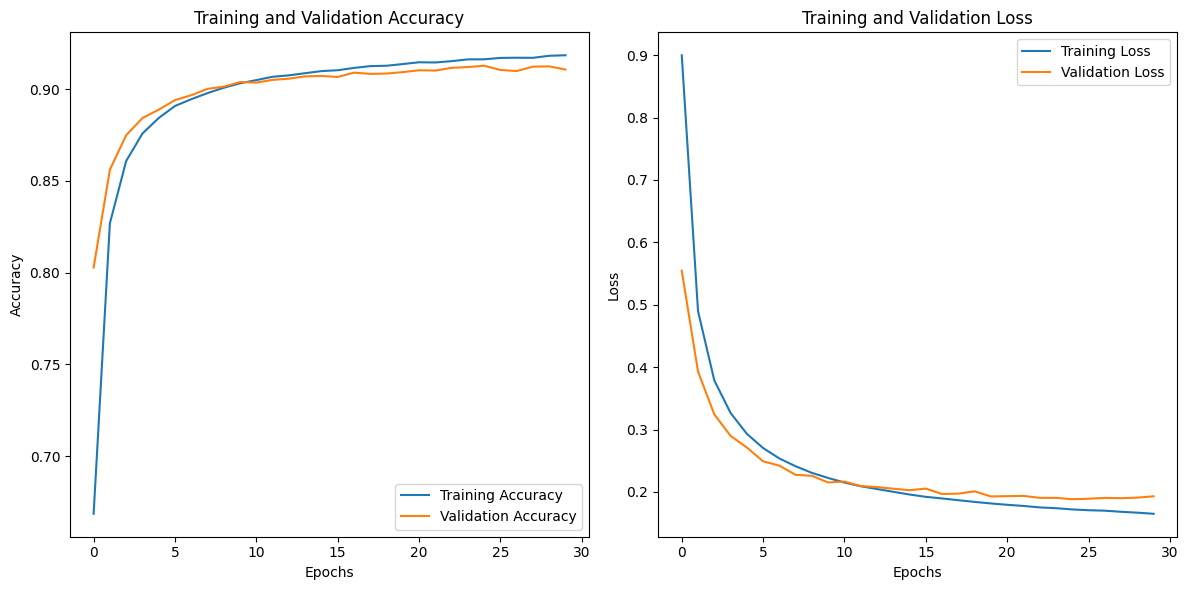

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     12099
           1       0.91      0.95      0.93     14078
           2       0.87      0.70      0.78      3449
           3       0.92      0.91      0.92      5723
           4       0.85      0.92      0.88      4766
           5       0.81      0.73      0.77      1496

    accuracy                           0.91     41611
   macro avg       0.89      0.86      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.16506211459636688
Val Loss: 0.19309478998184204
Test Loss: 0.1969808042049408
AUC: 0.9944651906466194
Accuracy: 0.9095671772956848
Precision: 0.9093768748209201
Recall: 0.9095671817548244
F1-Score: 0.9082655200703882

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


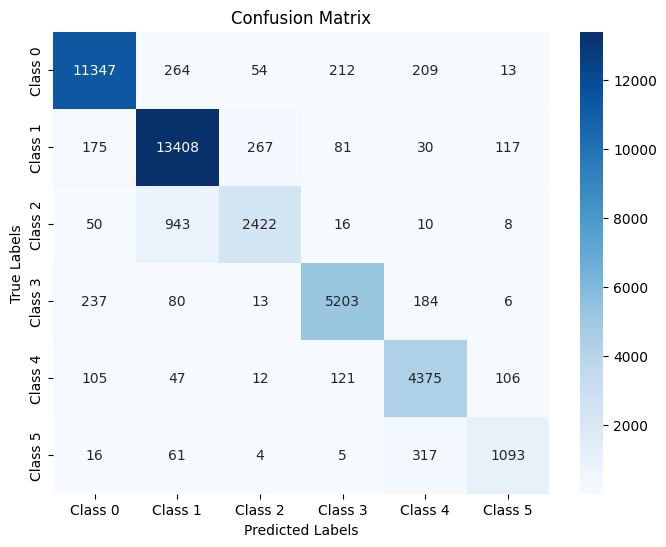


Model saved as 'glove_bigru_model_3.h5'



In [ ]:
glove_bigru_model_3, glove_bigru_metrics_3, glove_bigru_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_3.save('glove_bigru_model_3.h5')
print("\nModel saved as 'glove_bigru_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.7455 - loss: 0.7509 - val_accuracy: 0.8419 - val_loss: 0.4625
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 153s 7ms/step - accuracy: 0.8047 - loss: 0.5885 - val_accuracy: 0.8509 - val_loss: 0.4360
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - accuracy: 0.8121 - loss: 0.5645 - val_accuracy: 0.8506 - val_loss: 0.4247
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - accuracy: 0.8093 - loss: 0.5666 - val_accuracy: 0.8548 - val_loss: 0.4298
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - accuracy: 0.8118 - loss: 0.5555 - val_accuracy: 0.8617 - val_loss: 0.4440
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - accuracy: 0.8112 - loss: 0.5574 - val_accuracy: 0.8462 - val_loss: 0.4352
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - accuracy: 0.8150 - loss: 0.5461 - val_accuracy: 0.8607 - val_loss: 0.3950
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 153s 7ms/s

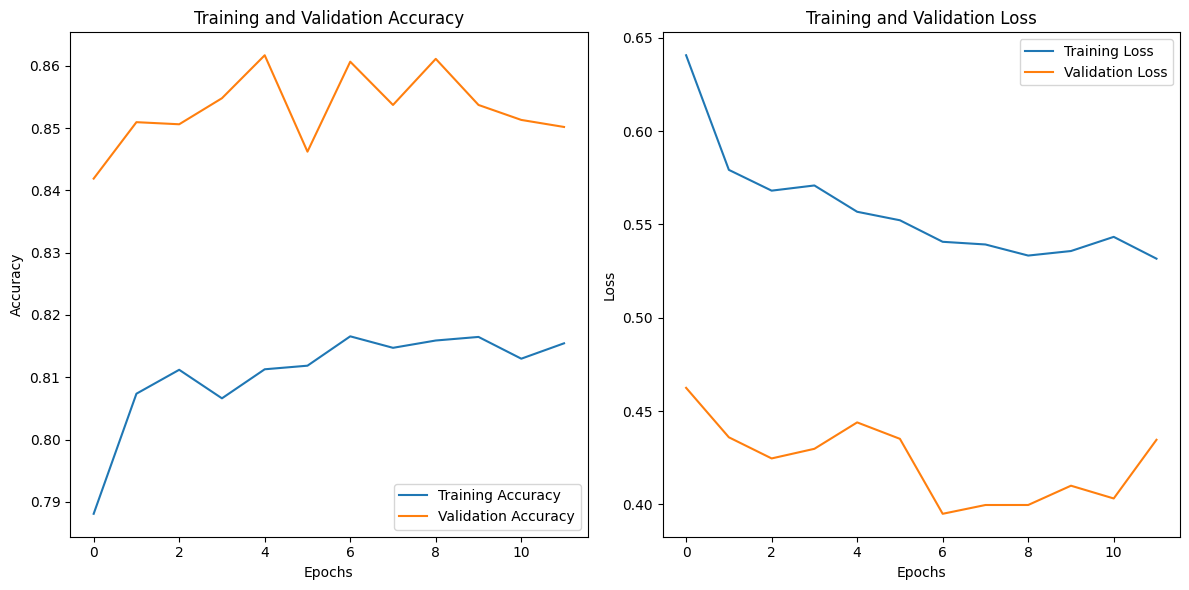

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.94      0.88     12099
           1       0.91      0.87      0.89     14078
           2       0.74      0.78      0.76      3449
           3       0.89      0.87      0.88      5723
           4       0.86      0.80      0.83      4766
           5       0.94      0.52      0.67      1496

    accuracy                           0.86     41611
   macro avg       0.86      0.79      0.82     41611
weighted avg       0.86      0.86      0.86     41611


Metrics:

Train Loss: 0.531654417514801
Val Loss: 0.4346485137939453
Test Loss: 0.4053135812282562
AUC: 0.9815678250727307
Accuracy: 0.8608300685882568
Precision: 0.864396624268009
Recall: 0.8608300689721468
F1-Score: 0.8592197040015027

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


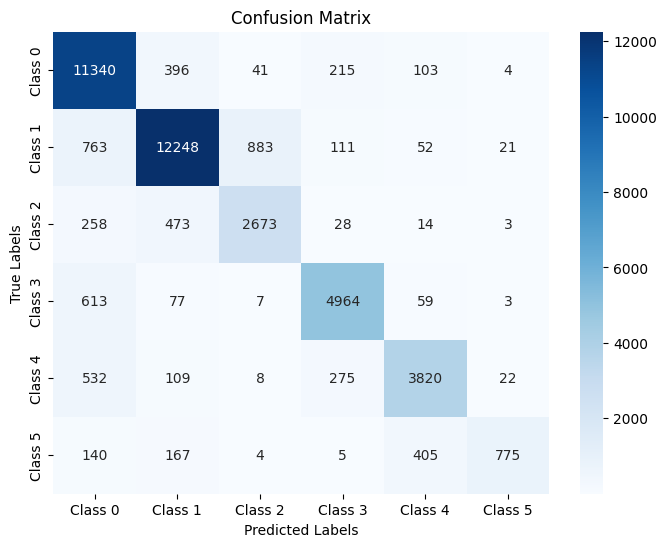


Model saved as 'glove_bigru_model_4.h5'



In [ ]:
glove_bigru_model_4, glove_bigru_metrics_4, glove_bigru_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_4.save('glove_bigru_model_4.h5')
print("\nModel saved as 'glove_bigru_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 158s 8ms/step - accuracy: 0.7528 - loss: 0.6725 - val_accuracy: 0.8914 - val_loss: 0.2718
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.8925 - loss: 0.2587 - val_accuracy: 0.9028 - val_loss: 0.2196
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 7ms/step - accuracy: 0.9022 - loss: 0.2267 - val_accuracy: 0.9065 - val_loss: 0.2044
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/step - accuracy: 0.9082 - loss: 0.2014 - val_accuracy: 0.9100 - val_loss: 0.1942
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/step - accuracy: 0.9114 - loss: 0.1907 - val_accuracy: 0.9113 - val_loss: 0.1947
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 154s 7ms/step - accuracy: 0.9137 - loss: 0.1844 - val_accuracy: 0.9146 - val_loss: 0.1906
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 156s 8ms/step - accuracy: 0.9137 - loss: 0.1812 - val_accuracy: 0.9127 - val_loss: 0.1813
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 155s 7ms/s

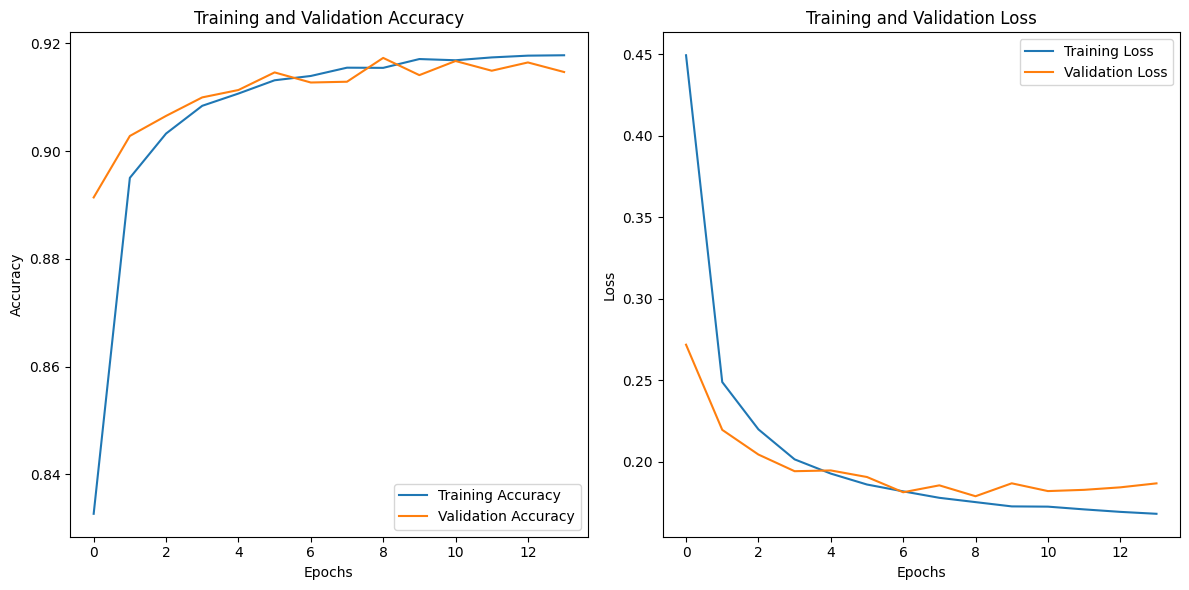

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12099
           1       0.91      0.96      0.93     14078
           2       0.88      0.70      0.78      3449
           3       0.90      0.95      0.92      5723
           4       0.92      0.84      0.88      4766
           5       0.79      0.83      0.81      1496

    accuracy                           0.91     41611
   macro avg       0.89      0.87      0.88     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.1680610477924347
Val Loss: 0.18673481047153473
Test Loss: 0.18098287284374237
AUC: 0.9951736648528957
Accuracy: 0.9141573309898376
Precision: 0.914053644906458
Recall: 0.9141573141717334
F1-Score: 0.9127763092993687

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


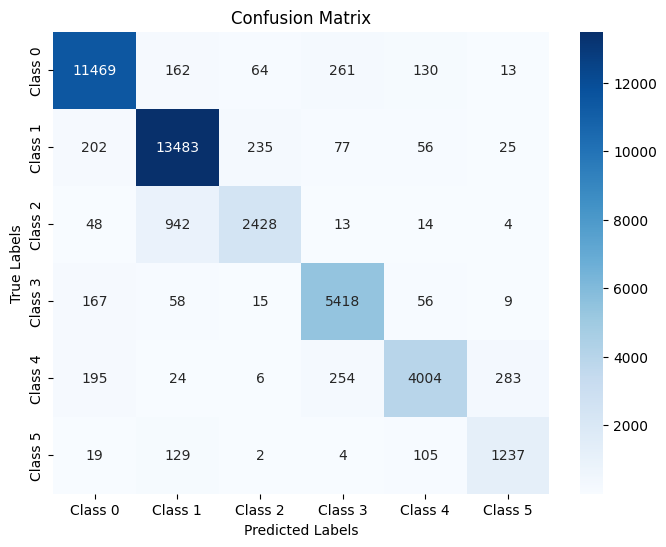


Model saved as 'glove_bigru_model_5.h5'



In [ ]:
glove_bigru_model_5, glove_bigru_metrics_5, glove_bigru_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_5.save('glove_bigru_model_5.h5')
print("\nModel saved as 'glove_bigru_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - accuracy: 0.5449 - loss: 1.2113 - val_accuracy: 0.7587 - val_loss: 0.6692
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.7701 - loss: 0.6450 - val_accuracy: 0.8259 - val_loss: 0.4816
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8312 - loss: 0.4770 - val_accuracy: 0.8586 - val_loss: 0.3841
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - accuracy: 0.8557 - loss: 0.3949 - val_accuracy: 0.8698 - val_loss: 0.3375
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - accuracy: 0.8687 - loss: 0.3505 - val_accuracy: 0.8808 - val_loss: 0.3100
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - accuracy: 0.8780 - loss: 0.3181 - val_accuracy: 0.8818 - val_loss: 0.2947
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - accuracy: 0.8847 - loss: 0.2967 - val_accuracy: 0.8891 - val_loss: 0.2732
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/s

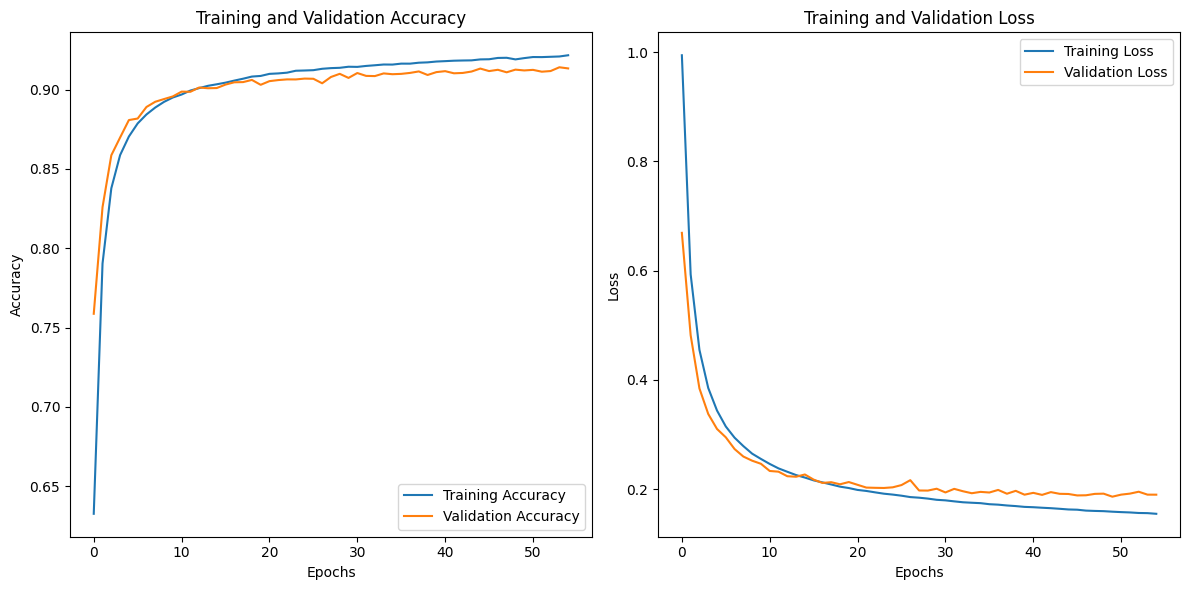

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     12099
           1       0.95      0.90      0.93     14078
           2       0.77      0.87      0.81      3449
           3       0.90      0.93      0.91      5723
           4       0.88      0.87      0.88      4766
           5       0.80      0.74      0.77      1496

    accuracy                           0.91     41611
   macro avg       0.87      0.88      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.15461355447769165
Val Loss: 0.18963047862052917
Test Loss: 0.19080689549446106
AUC: 0.9947906590285965
Accuracy: 0.9090865254402161
Precision: 0.9109943703372625
Recall: 0.9090865396169282
F1-Score: 0.9094202952333593

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


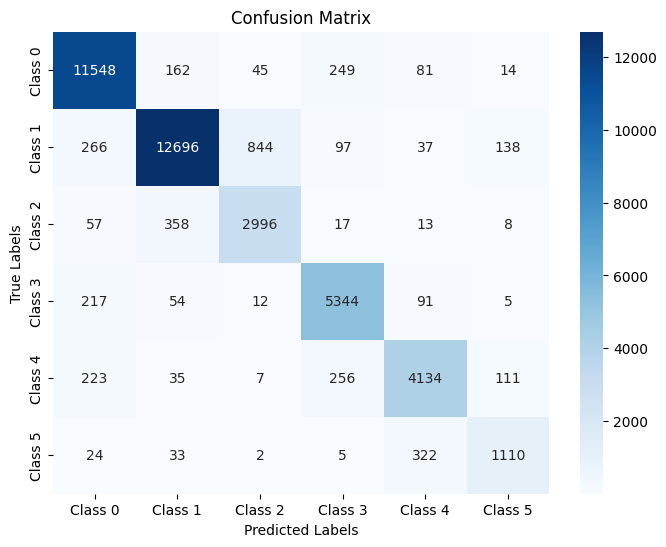


Model saved as 'glove_bigru_model_6.h5'



In [ ]:
glove_bigru_model_6, glove_bigru_metrics_6, glove_bigru_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_6.save('glove_bigru_model_6.h5')
print("\nModel saved as 'glove_bigru_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 89s 8ms/step - accuracy: 0.7806 - loss: 0.6298 - val_accuracy: 0.8669 - val_loss: 0.3676
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.8570 - loss: 0.4095 - val_accuracy: 0.8798 - val_loss: 0.3194
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.8555 - loss: 0.4073 - val_accuracy: 0.8777 - val_loss: 0.3179
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.8548 - loss: 0.4118 - val_accuracy: 0.8784 - val_loss: 0.3271
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.8539 - loss: 0.4088 - val_accuracy: 0.8763 - val_loss: 0.3358
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.8563 - loss: 0.4070 - val_accuracy: 0.8796 - val_loss: 0.3206
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.8531 - loss: 0.4165 - val_accuracy: 0.8788 - val_loss: 0.3196
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - ac

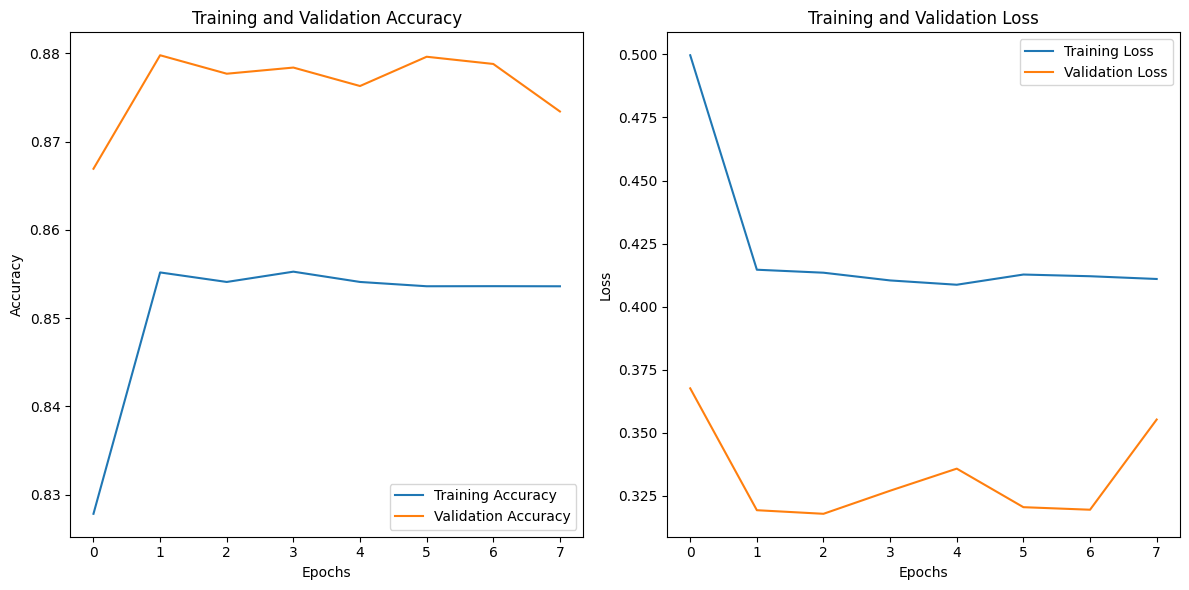

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     12099
           1       0.92      0.89      0.90     14078
           2       0.76      0.78      0.77      3449
           3       0.84      0.93      0.88      5723
           4       0.87      0.82      0.84      4766
           5       0.73      0.79      0.76      1496

    accuracy                           0.88     41611
   macro avg       0.84      0.85      0.84     41611
weighted avg       0.88      0.88      0.88     41611


Metrics:

Train Loss: 0.4109816253185272
Val Loss: 0.35529062151908875
Test Loss: 0.3177824318408966
AUC: 0.9884292898778471
Accuracy: 0.8764028549194336
Precision: 0.8780816000984195
Recall: 0.8764028742399846
F1-Score: 0.8767366436741019

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


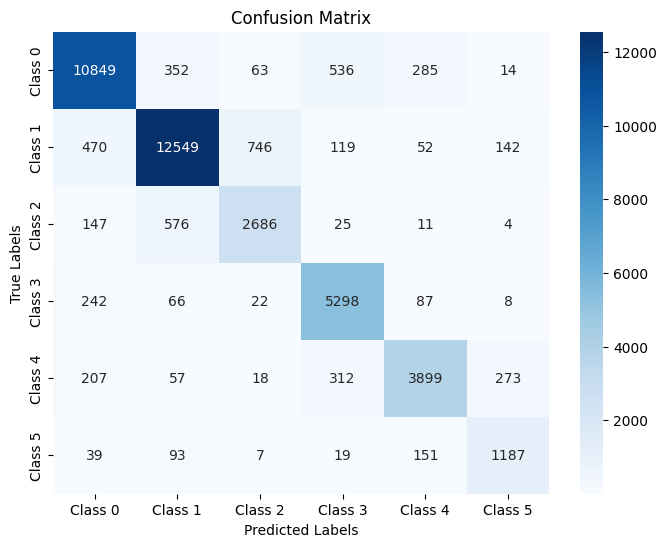


Model saved as 'glove_bigru_model_7.h5'



In [ ]:
glove_bigru_model_7, glove_bigru_metrics_7, glove_bigru_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_7.save('glove_bigru_model_7.h5')
print("\nModel saved as 'glove_bigru_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.7252 - loss: 0.7509 - val_accuracy: 0.8859 - val_loss: 0.2855
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8871 - loss: 0.2843 - val_accuracy: 0.8981 - val_loss: 0.2324
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8987 - loss: 0.2335 - val_accuracy: 0.9065 - val_loss: 0.2095
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.9059 - loss: 0.2100 - val_accuracy: 0.9053 - val_loss: 0.2069
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.9090 - loss: 0.1972 - val_accuracy: 0.9098 - val_loss: 0.1958
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.9118 - loss: 0.1873 - val_accuracy: 0.9100 - val_loss: 0.1914
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.9140 - loss: 0.1807 - val_accuracy: 0.9108 - val_loss: 0.1937
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - ac

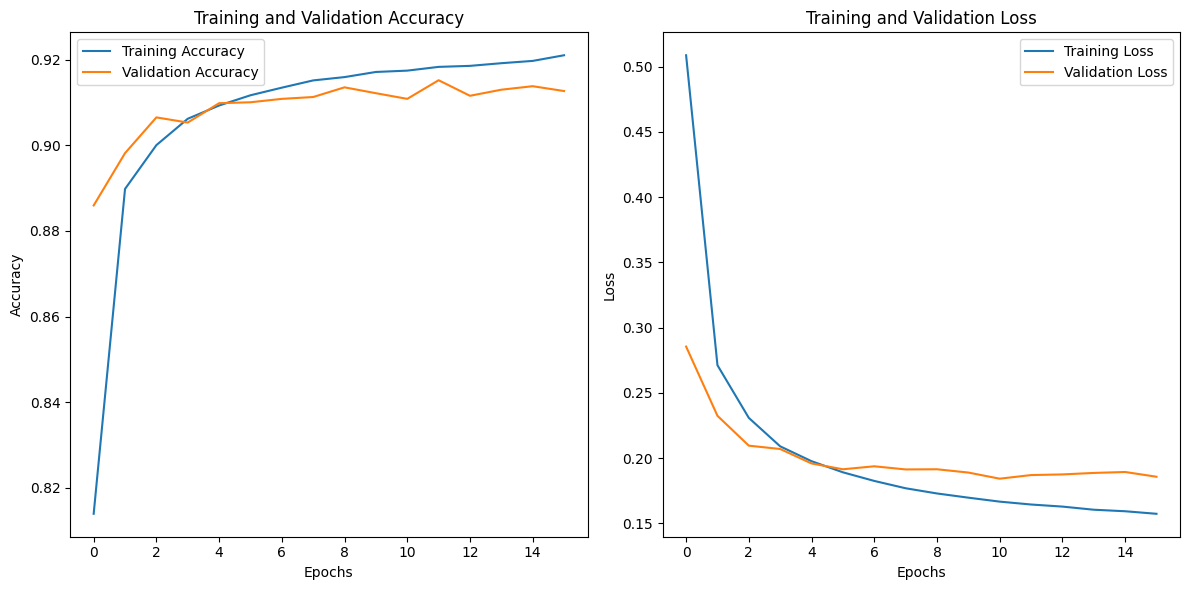

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12099
           1       0.96      0.90      0.93     14078
           2       0.77      0.88      0.82      3449
           3       0.95      0.88      0.92      5723
           4       0.90      0.86      0.88      4766
           5       0.73      0.93      0.82      1496

    accuracy                           0.91     41611
   macro avg       0.87      0.90      0.88     41611
weighted avg       0.92      0.91      0.91     41611


Metrics:

Train Loss: 0.15725356340408325
Val Loss: 0.18565671145915985
Test Loss: 0.18326561152935028
AUC: 0.9949713005801569
Accuracy: 0.9128355383872986
Precision: 0.9174615760614058
Recall: 0.9128355482925188
F1-Score: 0.9137667541947986

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


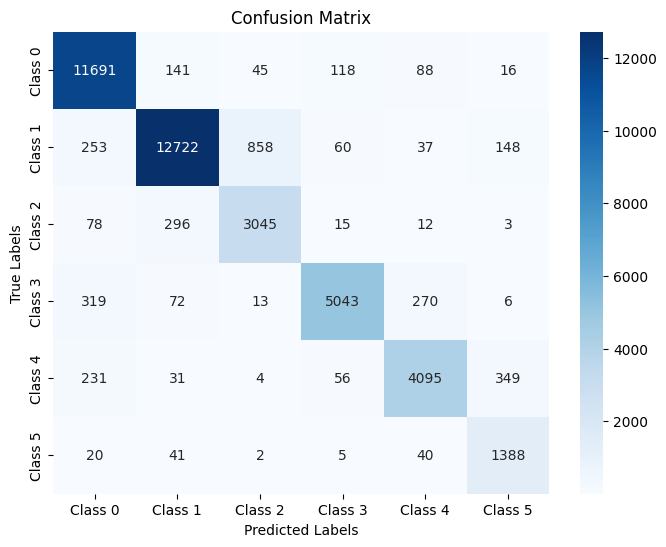


Model saved as 'glove_bigru_model_8.h5'



In [ ]:
glove_bigru_model_8, glove_bigru_metrics_8, glove_bigru_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_8.save('glove_bigru_model_8.h5')
print("\nModel saved as 'glove_bigru_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.5185 - loss: 1.2763 - val_accuracy: 0.7239 - val_loss: 0.7550
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.7373 - loss: 0.7316 - val_accuracy: 0.8086 - val_loss: 0.5380
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.8095 - loss: 0.5433 - val_accuracy: 0.8417 - val_loss: 0.4345
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.8424 - loss: 0.4466 - val_accuracy: 0.8618 - val_loss: 0.3704
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8602 - loss: 0.3877 - val_accuracy: 0.8734 - val_loss: 0.3328
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.8710 - loss: 0.3477 - val_accuracy: 0.8778 - val_loss: 0.3122
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.8780 - loss: 0.3216 - val_accuracy: 0.8857 - val_loss: 0.2861
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - ac

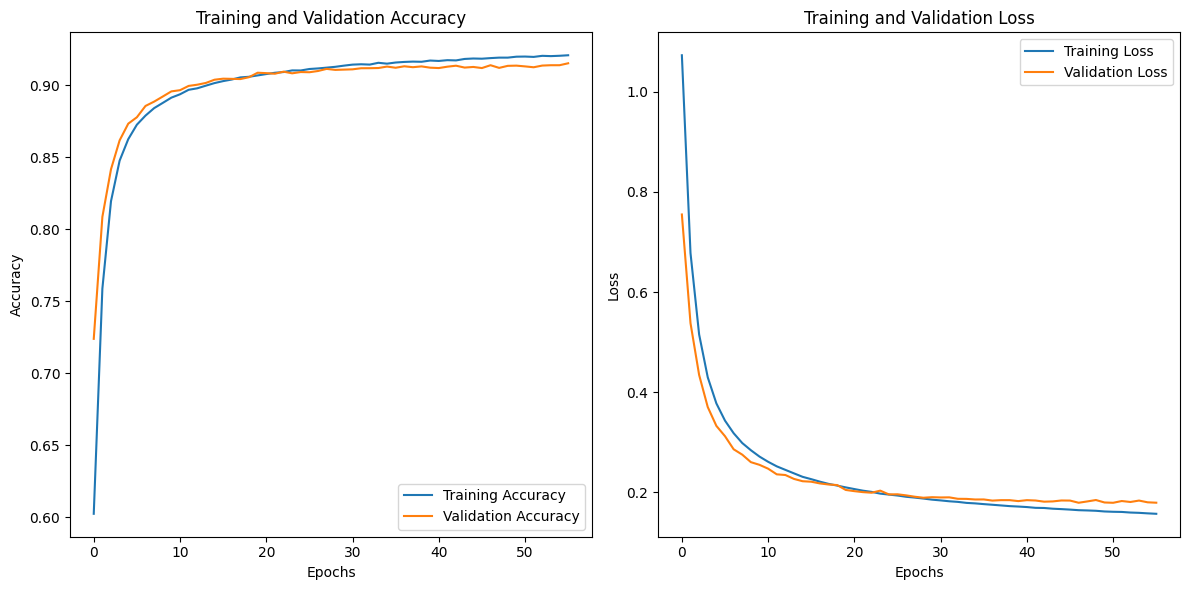

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     12099
           1       0.95      0.90      0.93     14078
           2       0.77      0.88      0.82      3449
           3       0.91      0.92      0.92      5723
           4       0.86      0.90      0.88      4766
           5       0.78      0.78      0.78      1496

    accuracy                           0.91     41611
   macro avg       0.87      0.89      0.88     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.15716463327407837
Val Loss: 0.1793147772550583
Test Loss: 0.1844496876001358
AUC: 0.9949956733981926
Accuracy: 0.9105044603347778
Precision: 0.9133750425257423
Recall: 0.910504433923722
F1-Score: 0.9113022190119708

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


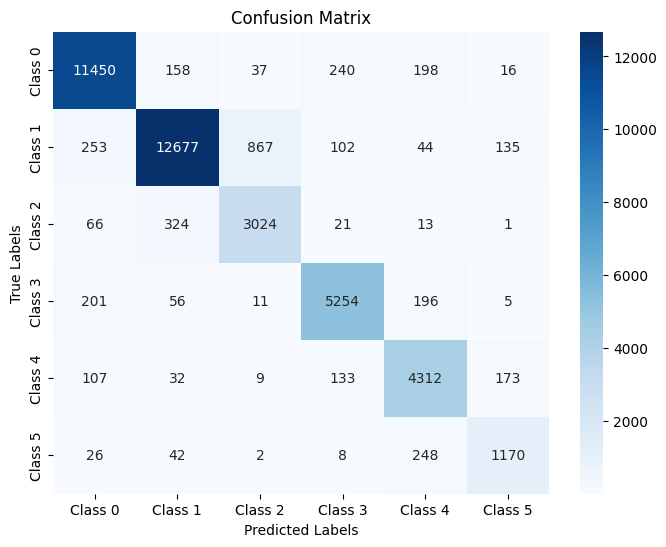


Model saved as 'glove_bigru_model_9.h5'



In [ ]:
glove_bigru_model_9, glove_bigru_metrics_9, glove_bigru_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bigru"
)

glove_bigru_model_9.save('glove_bigru_model_9.h5')
print("\nModel saved as 'glove_bigru_model_9.h5'\n")

## LSTM

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 206s 5ms/step - accuracy: 0.3353 - loss: 1.5778 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3357 - loss: 1.5729 - val_accuracy: 0.3383 - val_loss: 1.5736
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.3379 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5736
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 206s 5ms/step - accuracy: 0.3378 - loss: 1.5732 - val_accuracy: 0.3383 - val_loss: 1.5735
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3354 - loss: 1.5748 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3376 - loss: 1.5737 - val_accuracy: 0.3383 - val_loss: 1.5743
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



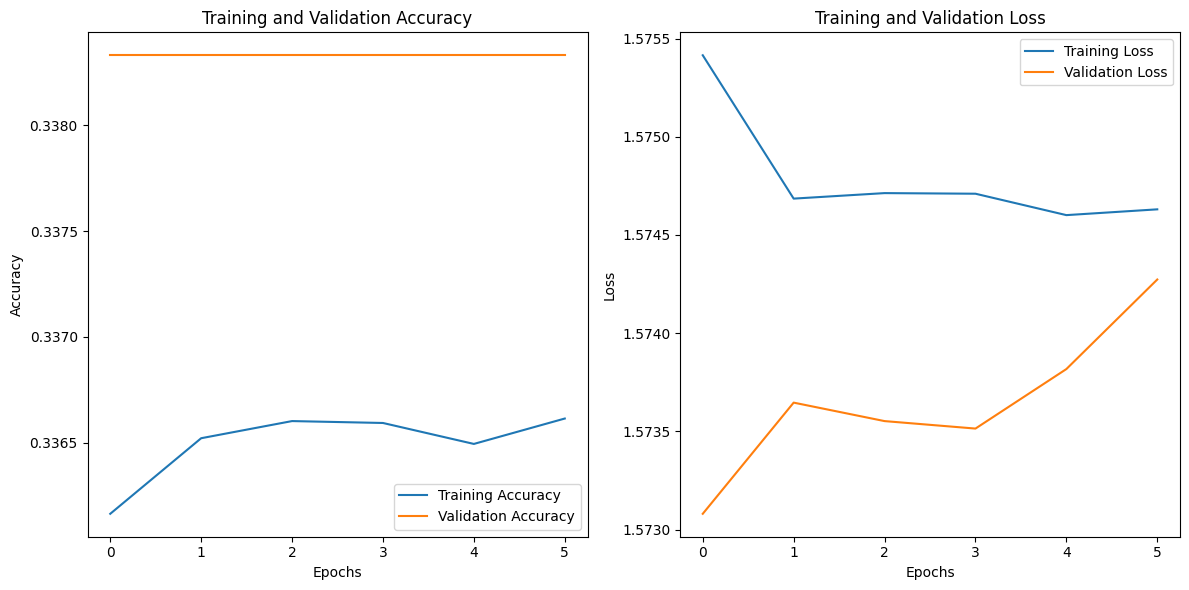

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5746304988861084
Val Loss: 1.5742733478546143
Test Loss: 1.573056936264038
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


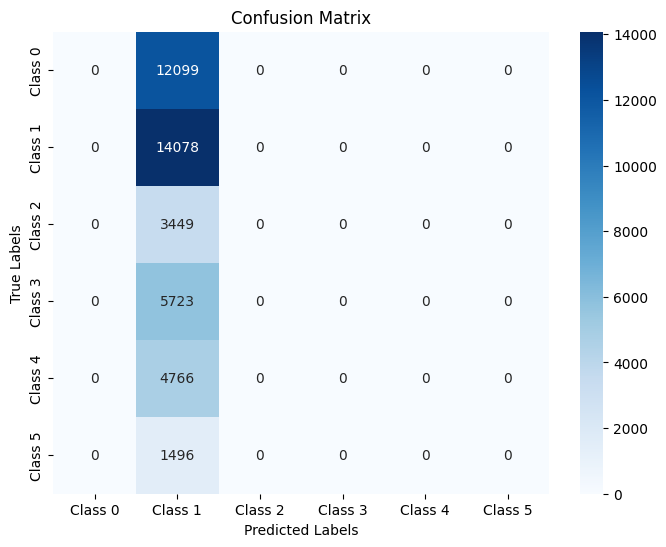


Model saved as 'glove_lstm_model_1.h5'



In [ ]:
glove_lstm_model_1, glove_lstm_metrics_1, glove_lstm_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_1.save('glove_lstm_model_1.h5')
print("\nModel saved as 'glove_lstm_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 205s 5ms/step - accuracy: 0.3340 - loss: 1.5811 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.3387 - loss: 1.5737 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3376 - loss: 1.5736 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3384 - loss: 1.5736 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3392 - loss: 1.5716 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3399 - loss: 1.5722 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/step - accuracy: 0.3388 - loss: 1.5732 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 203s 5ms/s

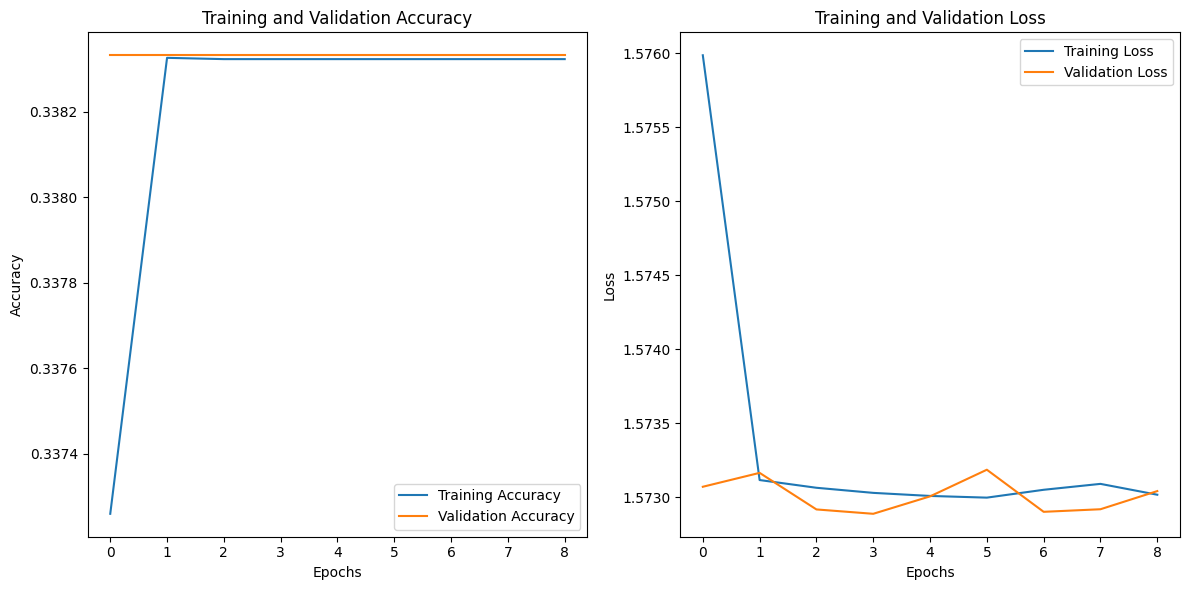

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.573015809059143
Val Loss: 1.5730403661727905
Test Loss: 1.572866439819336
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


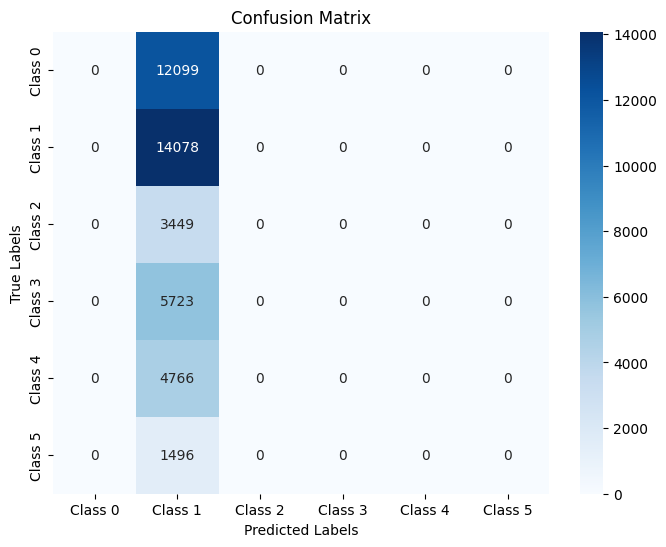


Model saved as 'glove_lstm_model_2.h5'



In [ ]:
glove_lstm_model_2, glove_lstm_metrics_2, glove_lstm_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_2.save('glove_lstm_model_2.h5')
print("\nModel saved as 'glove_lstm_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 205s 5ms/step - accuracy: 0.4863 - loss: 1.3437 - val_accuracy: 0.6266 - val_loss: 1.0385
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 201s 5ms/step - accuracy: 0.6541 - loss: 0.9698 - val_accuracy: 0.7173 - val_loss: 0.7819
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 201s 5ms/step - accuracy: 0.7452 - loss: 0.7226 - val_accuracy: 0.8008 - val_loss: 0.5547
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.8139 - loss: 0.5261 - val_accuracy: 0.8475 - val_loss: 0.4132
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 201s 5ms/step - accuracy: 0.8478 - loss: 0.4232 - val_accuracy: 0.8591 - val_loss: 0.3864
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.8631 - loss: 0.3715 - val_accuracy: 0.8740 - val_loss: 0.3308
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 202s 5ms/step - accuracy: 0.8740 - loss: 0.3366 - val_accuracy: 0.8716 - val_loss: 0.3472
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 201s 5ms/s

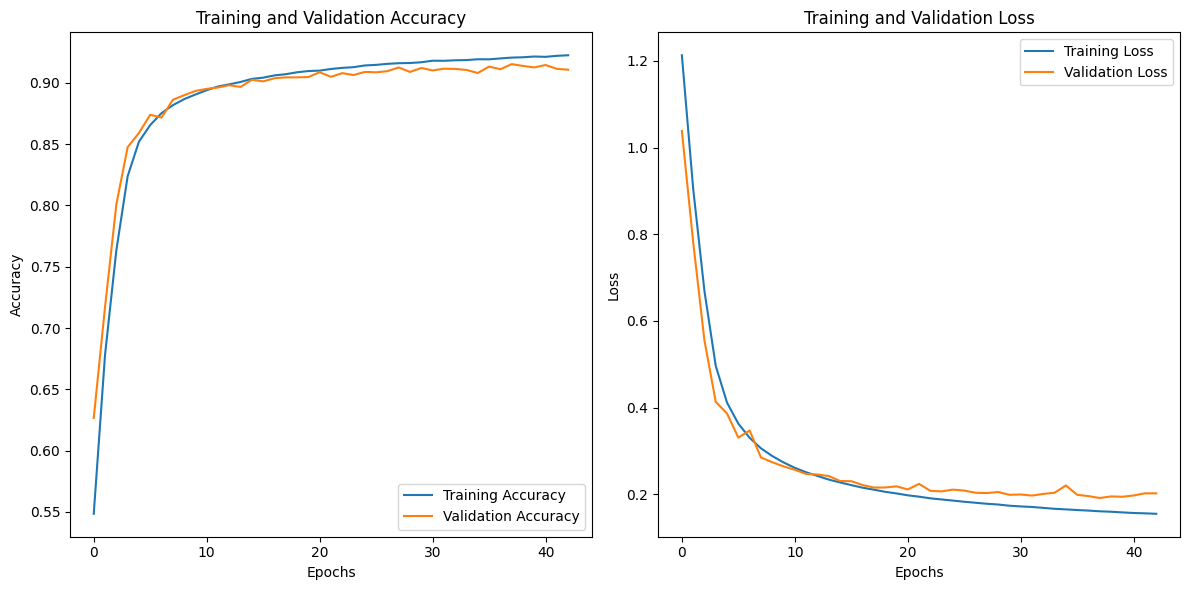

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     12099
           1       0.94      0.92      0.93     14078
           2       0.77      0.84      0.80      3449
           3       0.89      0.94      0.91      5723
           4       0.89      0.86      0.88      4766
           5       0.93      0.61      0.74      1496

    accuracy                           0.91     41611
   macro avg       0.89      0.86      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.15510085225105286
Val Loss: 0.20230087637901306
Test Loss: 0.19707895815372467
AUC: 0.994134032573656
Accuracy: 0.9105044603347778
Precision: 0.9117892679229906
Recall: 0.910504433923722
F1-Score: 0.9096656905513479

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


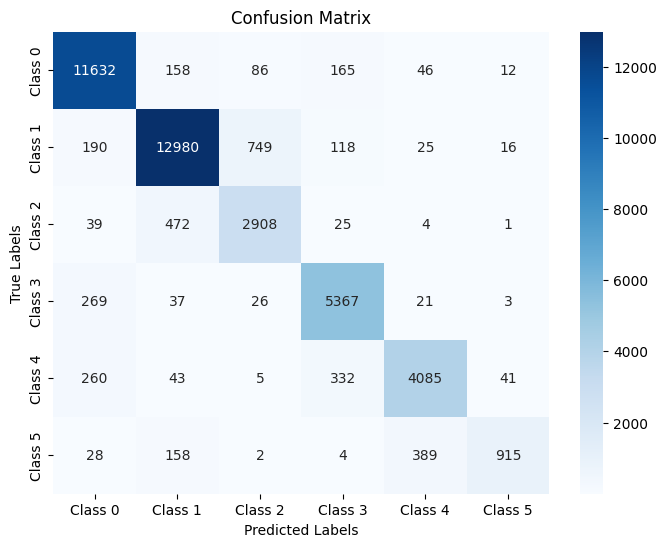


Model saved as 'glove_lstm_model_3.h5'



In [ ]:
glove_lstm_model_3, glove_lstm_metrics_3, glove_lstm_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_3.save('glove_lstm_model_3.h5')
print("\nModel saved as 'glove_lstm_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - accuracy: 0.3364 - loss: 1.5772 - val_accuracy: 0.3383 - val_loss: 1.5732
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.3376 - loss: 1.5738 - val_accuracy: 0.3383 - val_loss: 1.5758
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.3364 - loss: 1.5751 - val_accuracy: 0.3383 - val_loss: 1.5738
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.3363 - loss: 1.5754 - val_accuracy: 0.3383 - val_loss: 1.5743
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.3366 - loss: 1.5744 - val_accuracy: 0.3383 - val_loss: 1.5740
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.3368 - loss: 1.5775 - val_accuracy: 0.3383 - val_loss: 1.5736
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training History:



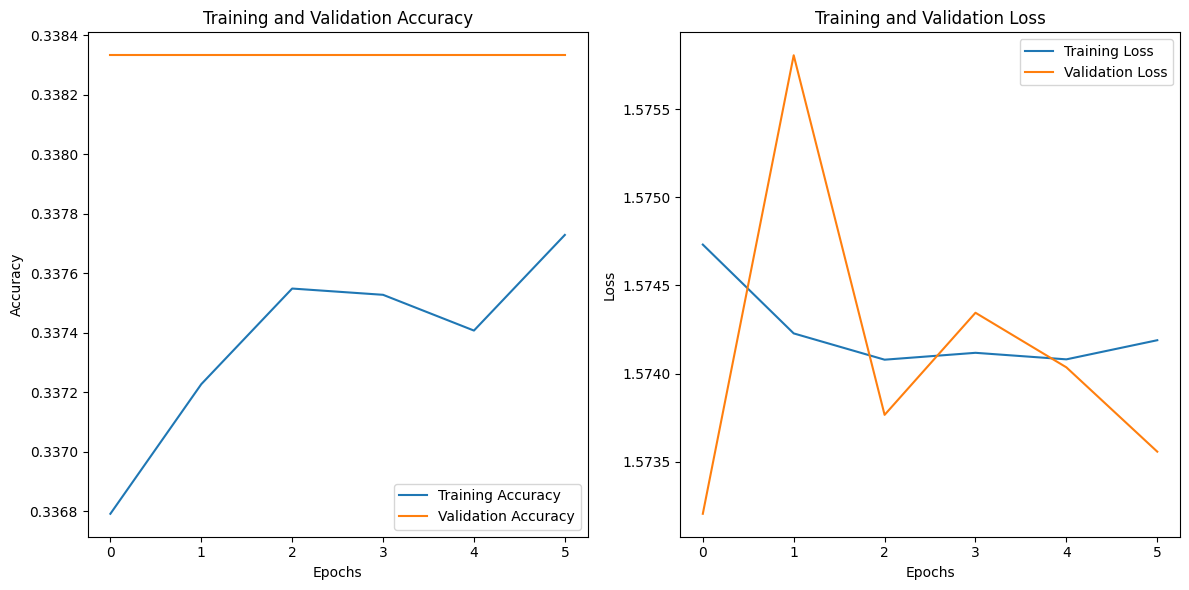

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5741891860961914
Val Loss: 1.5735573768615723
Test Loss: 1.5731829404830933
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


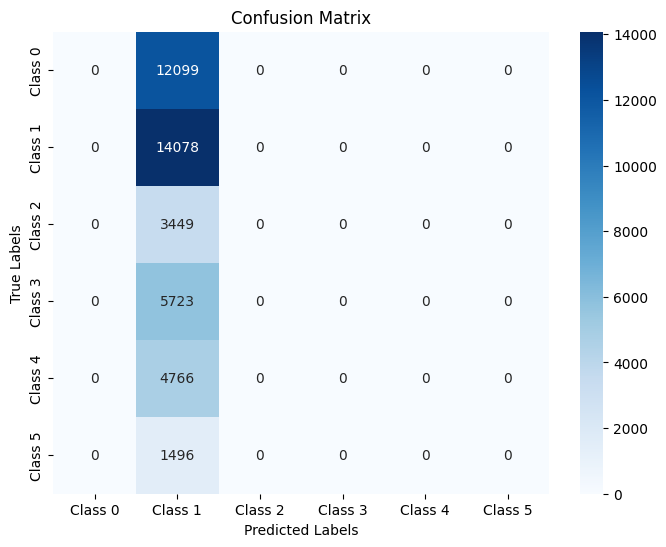


Model saved as 'glove_lstm_model_4.h5'



In [ ]:
glove_lstm_model_4, glove_lstm_metrics_4, glove_lstm_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_4.save('glove_lstm_model_4.h5')
print("\nModel saved as 'glove_lstm_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - accuracy: 0.5961 - loss: 1.0861 - val_accuracy: 0.8486 - val_loss: 0.4208
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.8795 - loss: 0.3250 - val_accuracy: 0.9022 - val_loss: 0.2237
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.9024 - loss: 0.2345 - val_accuracy: 0.9098 - val_loss: 0.1973
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.9099 - loss: 0.2045 - val_accuracy: 0.9112 - val_loss: 0.1901
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.9148 - loss: 0.1868 - val_accuracy: 0.9166 - val_loss: 0.1811
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.9176 - loss: 0.1754 - val_accuracy: 0.9171 - val_loss: 0.1802
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.9205 - loss: 0.1675 - val_accuracy: 0.9190 - val_loss: 0.1736
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step -

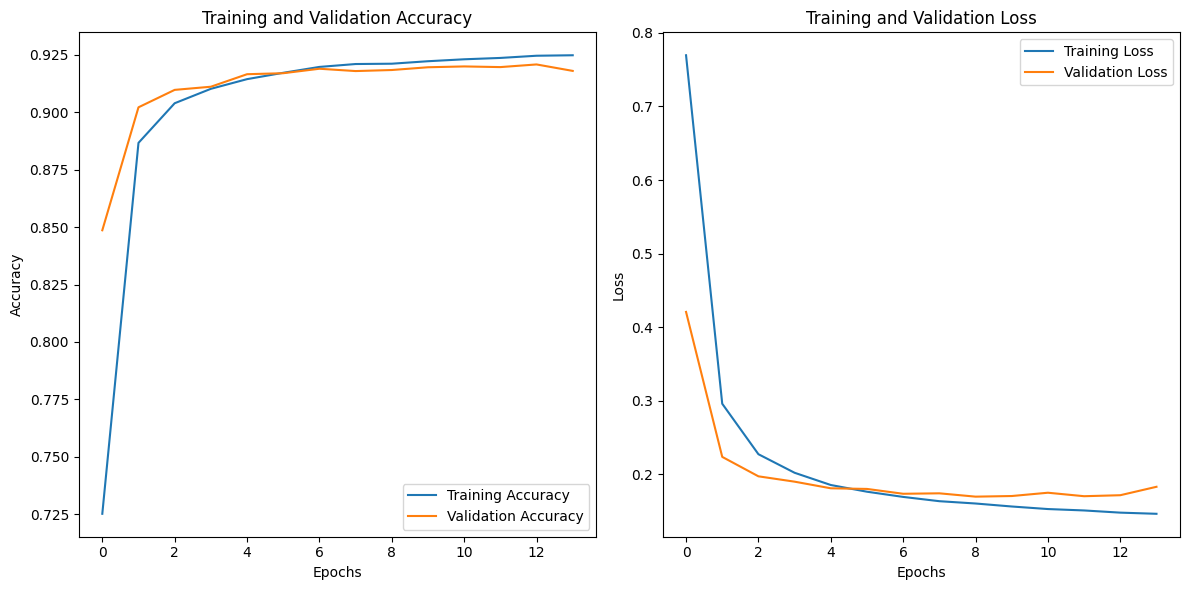

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     12099
           1       0.97      0.89      0.93     14078
           2       0.75      0.94      0.83      3449
           3       0.87      0.97      0.92      5723
           4       0.95      0.82      0.88      4766
           5       0.75      0.92      0.82      1496

    accuracy                           0.92     41611
   macro avg       0.87      0.92      0.89     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.14639626443386078
Val Loss: 0.18310120701789856
Test Loss: 0.17525352537631989
AUC: 0.995211832258736
Accuracy: 0.9163923263549805
Precision: 0.9243236491115441
Recall: 0.9163923001129509
F1-Score: 0.9176001562768752

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


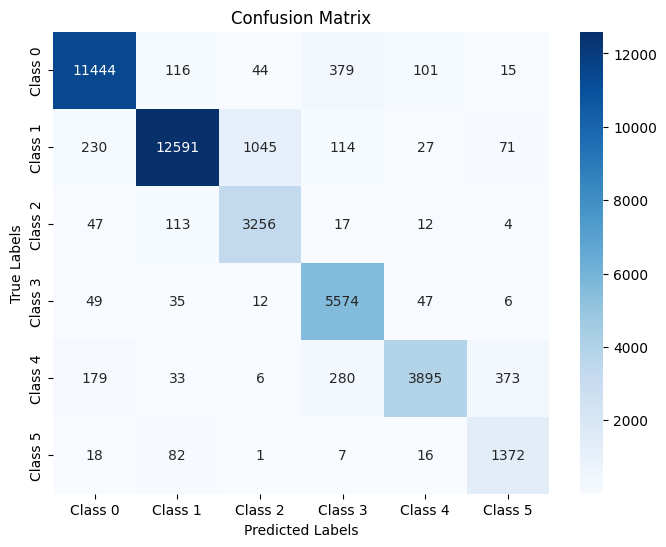


Model saved as 'glove_lstm_model_5.h5'



In [ ]:
glove_lstm_model_5, glove_lstm_metrics_5, glove_lstm_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_5.save('glove_lstm_model_5.h5')
print("\nModel saved as 'glove_lstm_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - accuracy: 0.4778 - loss: 1.3702 - val_accuracy: 0.5922 - val_loss: 1.1093
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.6054 - loss: 1.0858 - val_accuracy: 0.6486 - val_loss: 0.9484
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.6740 - loss: 0.8937 - val_accuracy: 0.7161 - val_loss: 0.7654
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.7324 - loss: 0.7277 - val_accuracy: 0.7704 - val_loss: 0.6311
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.7784 - loss: 0.6110 - val_accuracy: 0.8053 - val_loss: 0.5363
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.8097 - loss: 0.5378 - val_accuracy: 0.8272 - val_loss: 0.4793
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - accuracy: 0.8317 - loss: 0.4806 - val_accuracy: 0.8455 - val_loss: 0.4303
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 99s 5ms/step - 

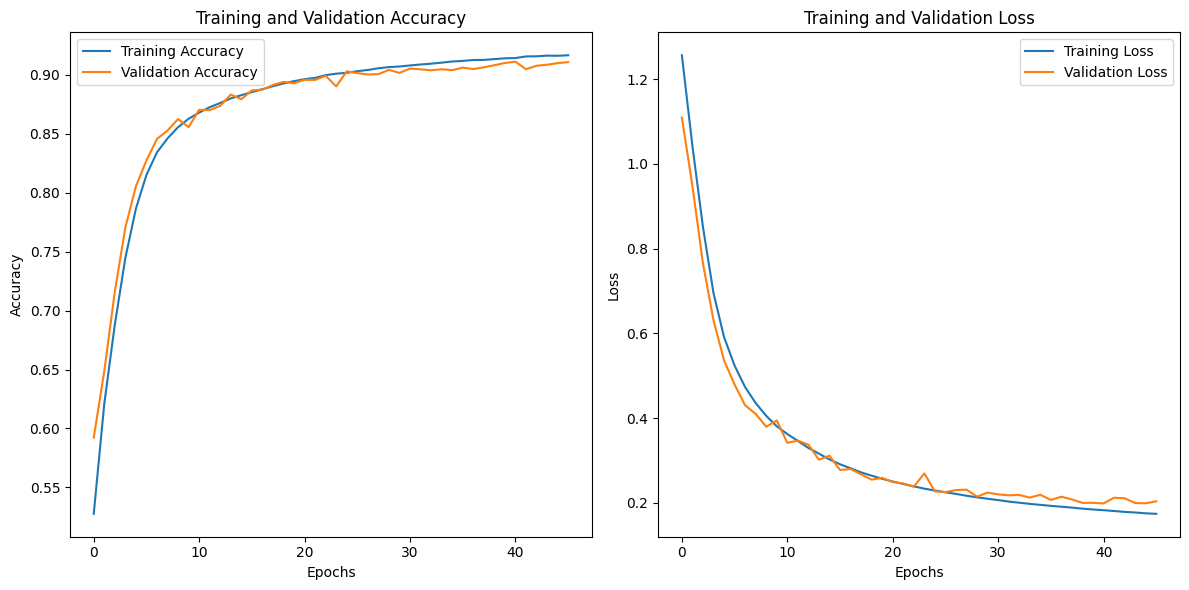

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     12099
           1       0.90      0.96      0.93     14078
           2       0.88      0.68      0.76      3449
           3       0.91      0.91      0.91      5723
           4       0.84      0.92      0.88      4766
           5       0.91      0.62      0.73      1496

    accuracy                           0.91     41611
   macro avg       0.90      0.84      0.86     41611
weighted avg       0.91      0.91      0.90     41611


Metrics:

Train Loss: 0.17437320947647095
Val Loss: 0.20386405289173126
Test Loss: 0.20652437210083008
AUC: 0.993789802662952
Accuracy: 0.9072360396385193
Precision: 0.9076491752101206
Recall: 0.9072360673860277
F1-Score: 0.9048720096905756

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


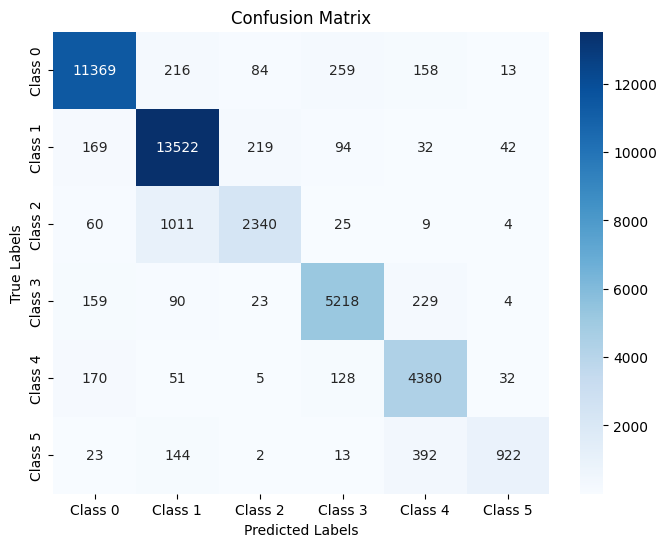


Model saved as 'glove_lstm_model_6.h5'



In [ ]:
glove_lstm_model_6, glove_lstm_metrics_6, glove_lstm_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_6.save('glove_lstm_model_6.h5')
print("\nModel saved as 'glove_lstm_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - accuracy: 0.3352 - loss: 1.5771 - val_accuracy: 0.3383 - val_loss: 1.5739
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3385 - loss: 1.5751 - val_accuracy: 0.2907 - val_loss: 1.5774
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.3368 - loss: 1.5740 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3389 - loss: 1.5720 - val_accuracy: 0.3383 - val_loss: 1.5740
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3369 - loss: 1.5732 - val_accuracy: 0.3383 - val_loss: 1.5736
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3379 - loss: 1.5741 - val_accuracy: 0.3383 - val_loss: 1.5737
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3374 - loss: 1.5732 - val_accuracy: 0.3383 - val_loss: 1.5733
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - ac

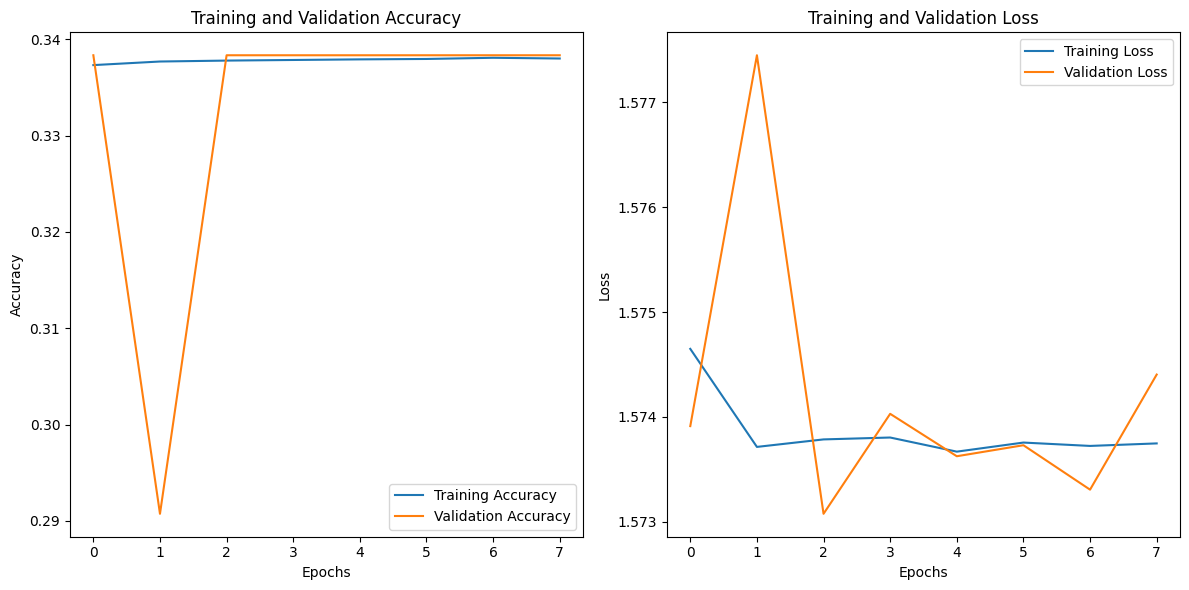

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.5737481117248535
Val Loss: 1.574404001235962
Test Loss: 1.5730547904968262
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


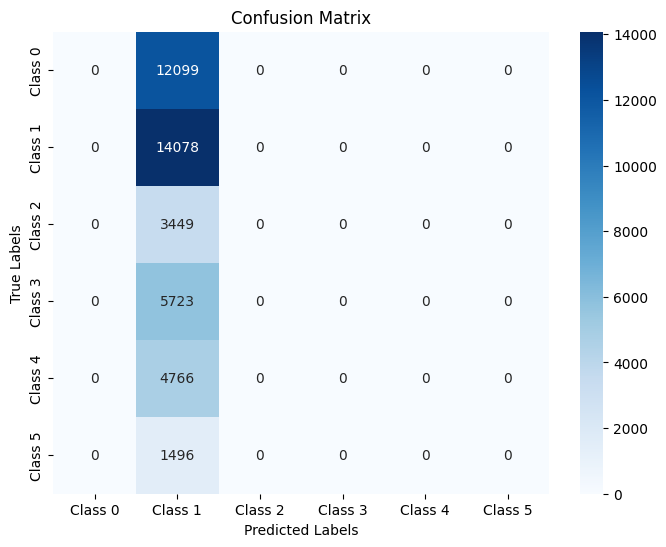


Model saved as 'glove_lstm_model_7.h5'



In [ ]:
glove_lstm_model_7, glove_lstm_metrics_7, glove_lstm_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_7.save('glove_lstm_model_7.h5')
print("\nModel saved as 'glove_lstm_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.3330 - loss: 1.5825 - val_accuracy: 0.3383 - val_loss: 1.5733
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3398 - loss: 1.5730 - val_accuracy: 0.3383 - val_loss: 1.5734
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3368 - loss: 1.5735 - val_accuracy: 0.3383 - val_loss: 1.5731
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3385 - loss: 1.5743 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3383 - loss: 1.5743 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3392 - loss: 1.5721 - val_accuracy: 0.3383 - val_loss: 1.5730
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.3385 - loss: 1.5718 - val_accuracy: 0.3383 - val_loss: 1.5729
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - ac

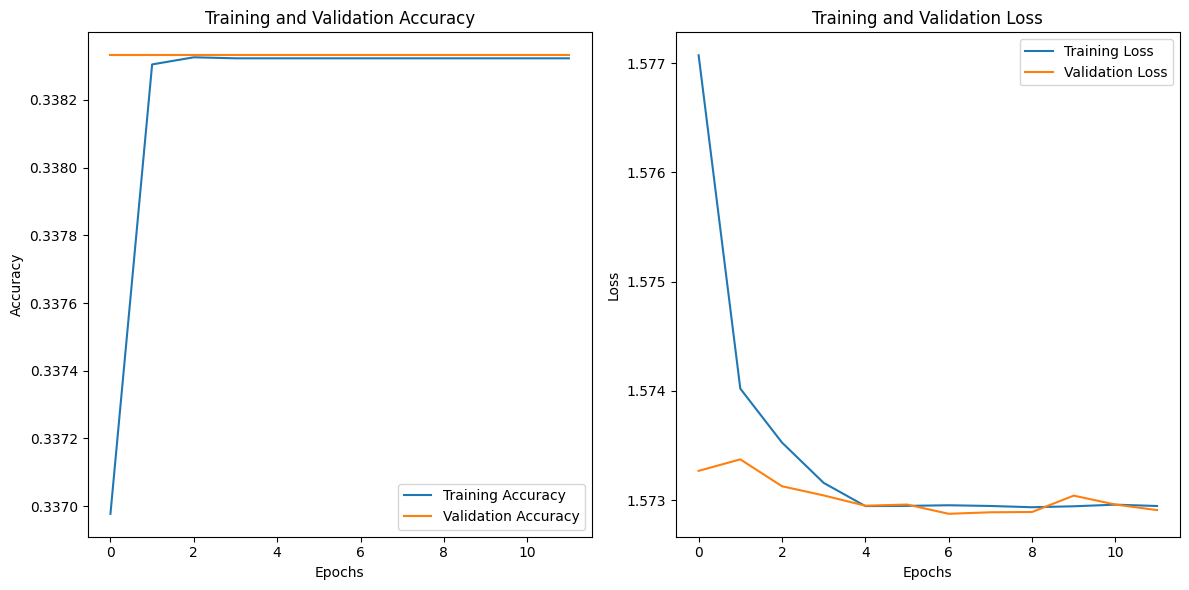

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12099
           1       0.34      1.00      0.51     14078
           2       0.00      0.00      0.00      3449
           3       0.00      0.00      0.00      5723
           4       0.00      0.00      0.00      4766
           5       0.00      0.00      0.00      1496

    accuracy                           0.34     41611
   macro avg       0.06      0.17      0.08     41611
weighted avg       0.11      0.34      0.17     41611


Metrics:

Train Loss: 1.572945475578308
Val Loss: 1.57290780544281
Test Loss: 1.5728548765182495
AUC: 0.5
Accuracy: 0.33832401037216187
Precision: 0.11446312956140597
Recall: 0.33832400086515585
F1-Score: 0.171054437471661

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


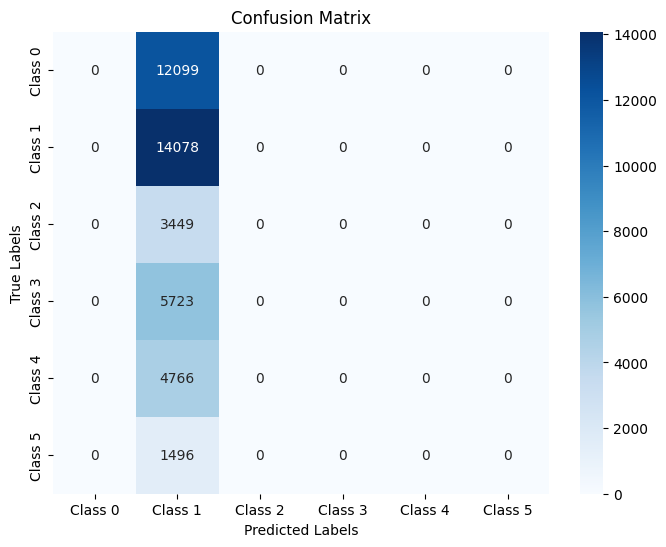


Model saved as 'glove_lstm_model_8.h5'



In [ ]:
glove_lstm_model_8, glove_lstm_metrics_8, glove_lstm_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_8.save('glove_lstm_model_8.h5')
print("\nModel saved as 'glove_lstm_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - accuracy: 0.4640 - loss: 1.3961 - val_accuracy: 0.6003 - val_loss: 1.0643
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.6150 - loss: 1.0353 - val_accuracy: 0.6565 - val_loss: 0.9012
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.6600 - loss: 0.8940 - val_accuracy: 0.7033 - val_loss: 0.7948
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.6972 - loss: 0.8051 - val_accuracy: 0.7321 - val_loss: 0.7313
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.7356 - loss: 0.7200 - val_accuracy: 0.7612 - val_loss: 0.6593
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.7683 - loss: 0.6436 - val_accuracy: 0.7867 - val_loss: 0.5922
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - accuracy: 0.7929 - loss: 0.5831 - val_accuracy: 0.8019 - val_loss: 0.5507
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - ac

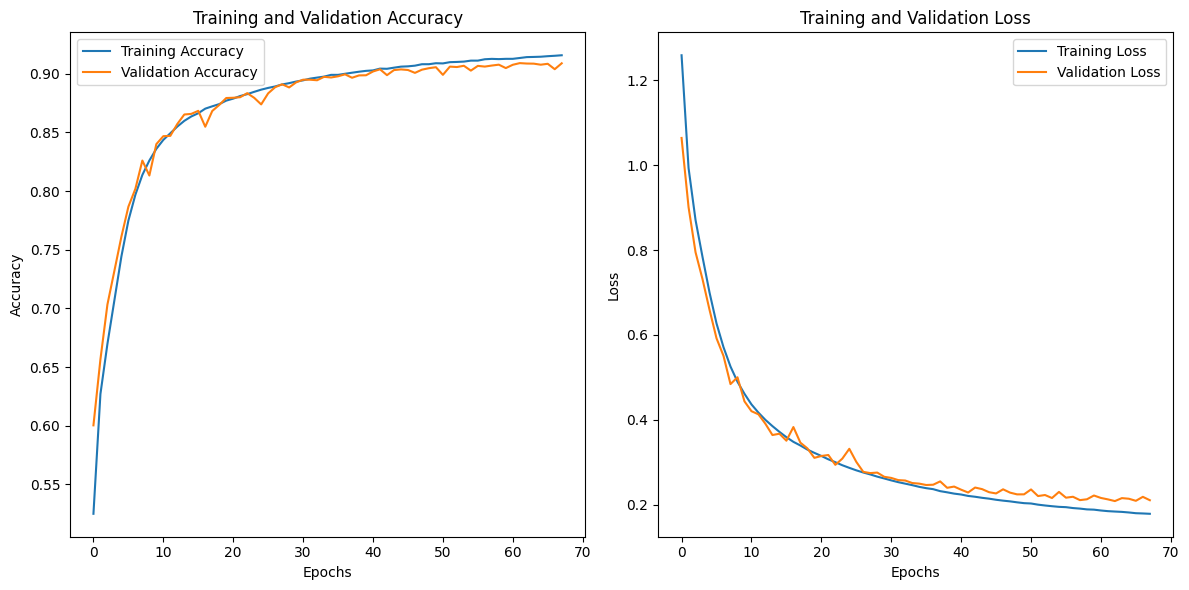

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     12099
           1       0.91      0.94      0.92     14078
           2       0.84      0.71      0.77      3449
           3       0.90      0.92      0.91      5723
           4       0.84      0.91      0.87      4766
           5       0.89      0.61      0.72      1496

    accuracy                           0.90     41611
   macro avg       0.89      0.84      0.86     41611
weighted avg       0.90      0.90      0.90     41611


Metrics:

Train Loss: 0.17861048877239227
Val Loss: 0.21059390902519226
Test Loss: 0.2133101522922516
AUC: 0.9932612854667426
Accuracy: 0.9036552906036377
Precision: 0.903415612121911
Recall: 0.9036552834587008
F1-Score: 0.9018273339809202

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


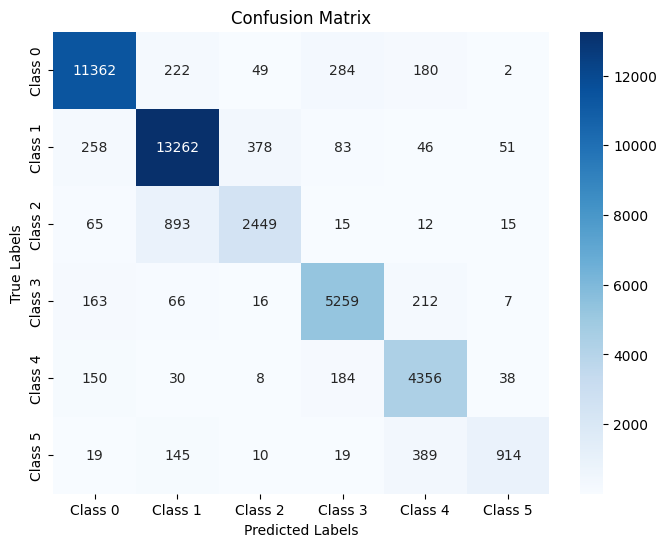


Model saved as 'glove_lstm_model_9.h5'



In [ ]:
glove_lstm_model_9, glove_lstm_metrics_9, glove_lstm_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="lstm"
)

glove_lstm_model_9.save('glove_lstm_model_9.h5')
print("\nModel saved as 'glove_lstm_model_9.h5'\n")

## Bi-LSTM

### 1. Batch 8 & LR 0.01

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 310s 7ms/step - accuracy: 0.7088 - loss: 0.8473 - val_accuracy: 0.8139 - val_loss: 0.5633
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/step - accuracy: 0.7955 - loss: 0.6222 - val_accuracy: 0.8097 - val_loss: 0.5718
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/step - accuracy: 0.8009 - loss: 0.6033 - val_accuracy: 0.8288 - val_loss: 0.5091
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/step - accuracy: 0.8126 - loss: 0.5756 - val_accuracy: 0.8340 - val_loss: 0.4932
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 306s 7ms/step - accuracy: 0.8120 - loss: 0.5769 - val_accuracy: 0.8364 - val_loss: 0.4924
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 306s 7ms/step - accuracy: 0.8146 - loss: 0.5748 - val_accuracy: 0.8376 - val_loss: 0.4928
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 306s 7ms/step - accuracy: 0.8177 - loss: 0.5672 - val_accuracy: 0.8350 - val_loss: 0.4833
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 307s 7ms/s

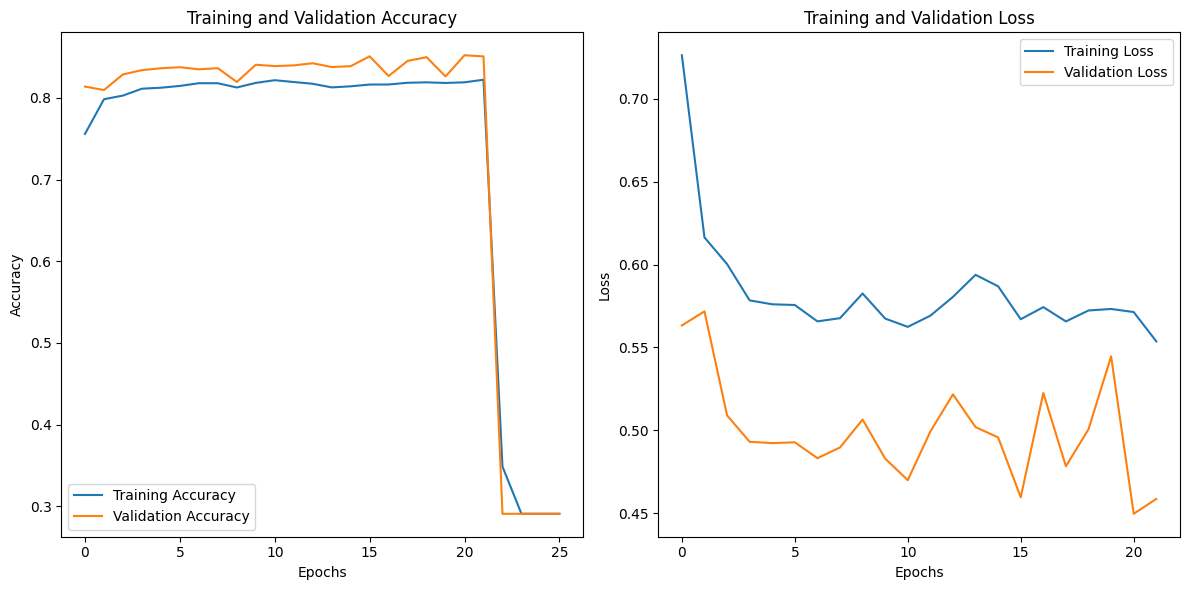

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     12099
           1       0.85      0.90      0.88     14078
           2       0.75      0.66      0.70      3449
           3       0.89      0.84      0.87      5723
           4       0.84      0.82      0.83      4766
           5       0.83      0.50      0.63      1496

    accuracy                           0.85     41611
   macro avg       0.84      0.77      0.80     41611
weighted avg       0.85      0.85      0.85     41611


Metrics:

Train Loss: nan
Val Loss: nan
Test Loss: 0.454572468996048
AUC: 0.9745292354630131
Accuracy: 0.8507846593856812
Precision: 0.8495951460509849
Recall: 0.8507846482901156
F1-Score: 0.847966088660102

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


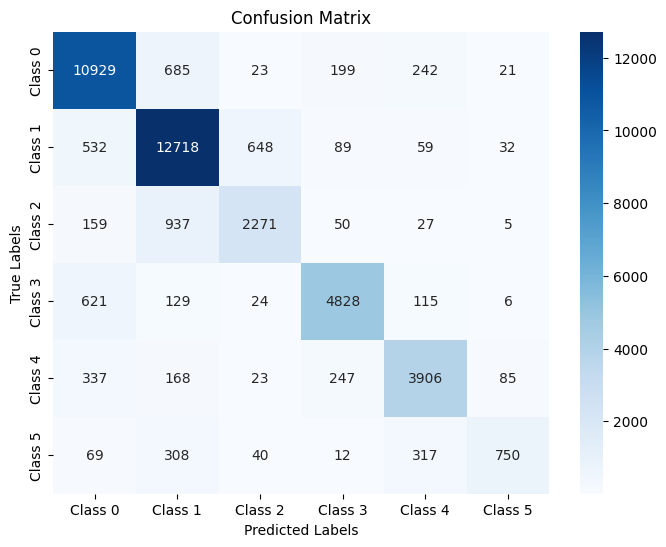


Model saved as 'glove_bilstm_model_1.h5'



In [ ]:
glove_bilstm_model_1, glove_bilstm_metrics_1, glove_bilstm_history_1 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_1.save('glove_bilstm_model_1.h5')
print("\nModel saved as 'glove_bilstm_model_1.h5'\n")

### 2. Batch 8 & LR 0.001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 309s 7ms/step - accuracy: 0.7561 - loss: 0.6614 - val_accuracy: 0.8900 - val_loss: 0.2573
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.8966 - loss: 0.2449 - val_accuracy: 0.9044 - val_loss: 0.2016
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.9079 - loss: 0.2040 - val_accuracy: 0.9133 - val_loss: 0.1837
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.9148 - loss: 0.1840 - val_accuracy: 0.9130 - val_loss: 0.1764
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.9173 - loss: 0.1734 - val_accuracy: 0.9161 - val_loss: 0.1712
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.9202 - loss: 0.1656 - val_accuracy: 0.9154 - val_loss: 0.1747
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.9213 - loss: 0.1602 - val_accuracy: 0.9199 - val_loss: 0.1664
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/s

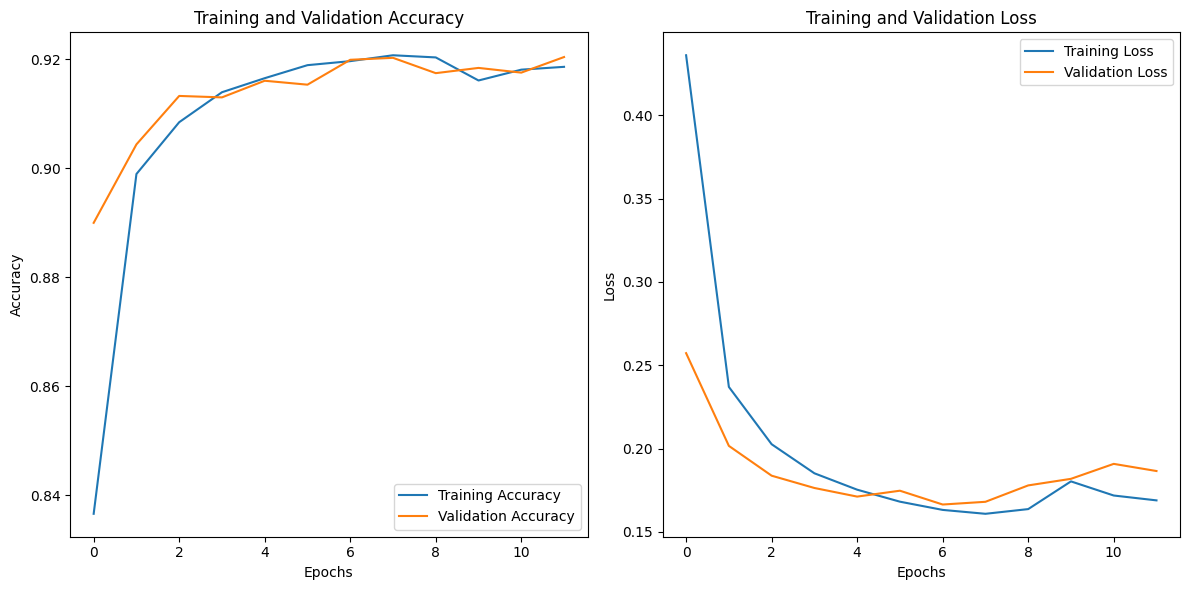

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     12099
           1       0.91      0.97      0.94     14078
           2       0.94      0.67      0.78      3449
           3       0.93      0.91      0.92      5723
           4       0.94      0.82      0.88      4766
           5       0.77      0.86      0.81      1496

    accuracy                           0.92     41611
   macro avg       0.90      0.87      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.1689193844795227
Val Loss: 0.18653544783592224
Test Loss: 0.1724773347377777
AUC: 0.9956311261794776
Accuracy: 0.9173535704612732
Precision: 0.9190778665106006
Recall: 0.9173535843887434
F1-Score: 0.9152662856636894

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


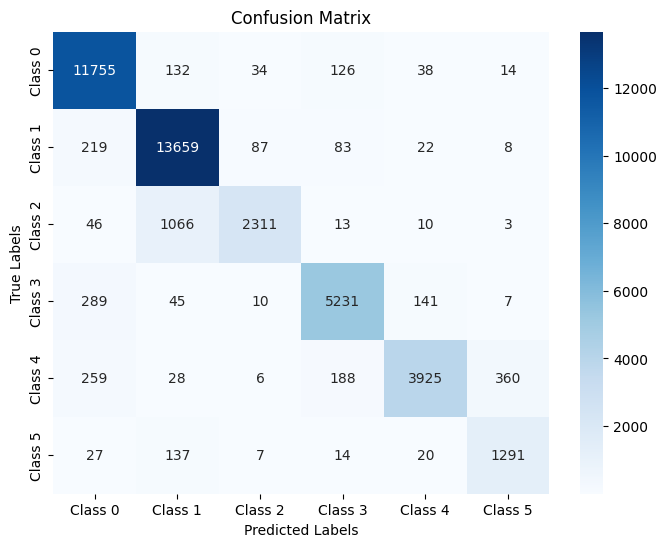


Model saved as 'glove_bilstm_model_2.h5'



In [ ]:
glove_bilstm_model_2, glove_bilstm_metrics_2, glove_bilstm_history_2 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_2.save('glove_bilstm_model_2.h5')
print("\nModel saved as 'glove_bilstm_model_2.h5'\n")

### 3. Batch 8 & LR 0.0001

Epoch 1/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 308s 7ms/step - accuracy: 0.5659 - loss: 1.1496 - val_accuracy: 0.7746 - val_loss: 0.6137
Epoch 2/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.7881 - loss: 0.5870 - val_accuracy: 0.8456 - val_loss: 0.4118
Epoch 3/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 305s 7ms/step - accuracy: 0.8462 - loss: 0.4217 - val_accuracy: 0.8690 - val_loss: 0.3393
Epoch 4/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 306s 7ms/step - accuracy: 0.8685 - loss: 0.3473 - val_accuracy: 0.8774 - val_loss: 0.3022
Epoch 5/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 306s 7ms/step - accuracy: 0.8812 - loss: 0.3032 - val_accuracy: 0.8875 - val_loss: 0.2771
Epoch 6/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.8903 - loss: 0.2725 - val_accuracy: 0.8938 - val_loss: 0.2574
Epoch 7/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/step - accuracy: 0.8939 - loss: 0.2544 - val_accuracy: 0.8977 - val_loss: 0.2393
Epoch 8/100
41610/41610 ━━━━━━━━━━━━━━━━━━━━ 304s 7ms/s

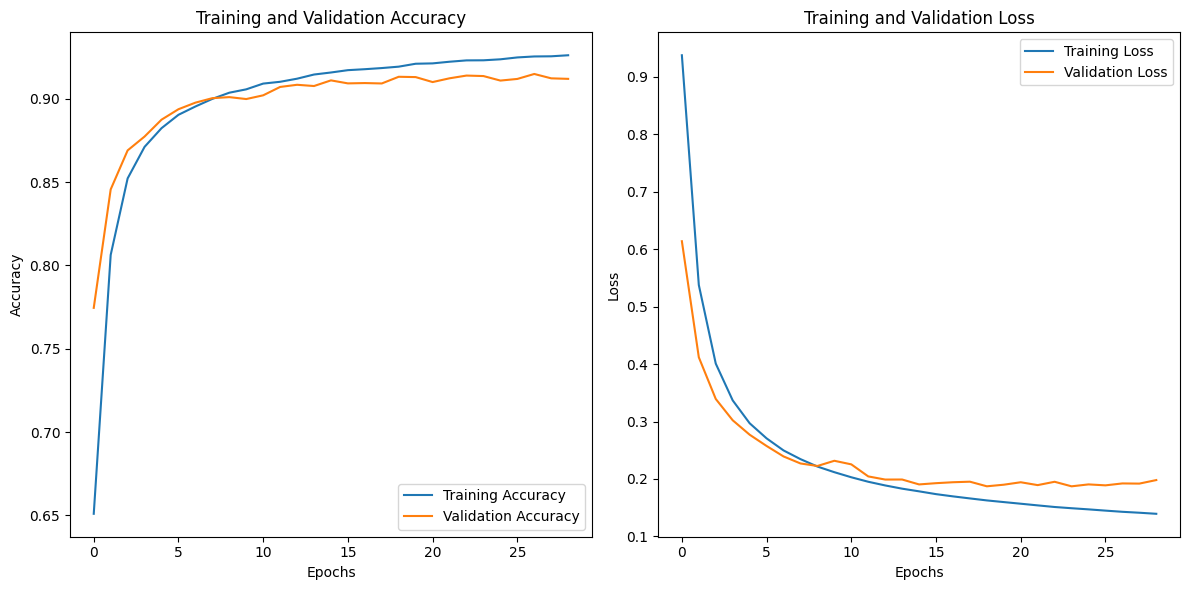

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     12099
           1       0.91      0.96      0.94     14078
           2       0.89      0.70      0.78      3449
           3       0.88      0.95      0.92      5723
           4       0.89      0.85      0.87      4766
           5       0.77      0.85      0.81      1496

    accuracy                           0.91     41611
   macro avg       0.88      0.87      0.88     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.13944241404533386
Val Loss: 0.1981390416622162
Test Loss: 0.19043397903442383
AUC: 0.9950421956042889
Accuracy: 0.9119223356246948
Precision: 0.9125502012957122
Recall: 0.911922328230516
F1-Score: 0.9107698606213471

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


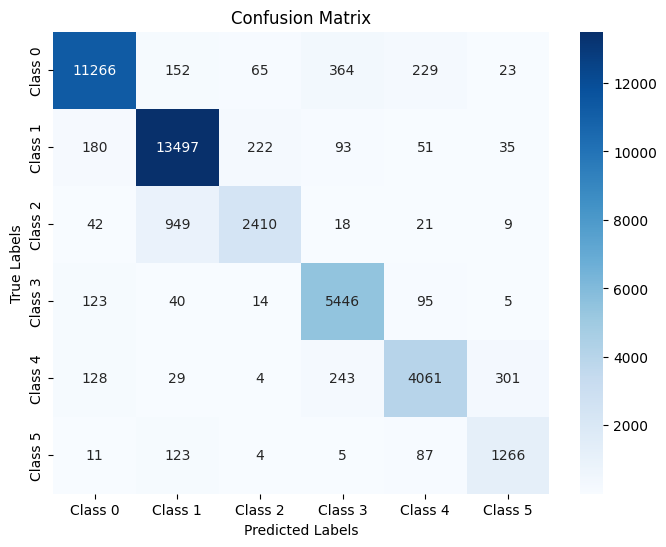


Model saved as 'glove_bilstm_model_3.h5'



In [ ]:
glove_bilstm_model_3, glove_bilstm_metrics_3, glove_bilstm_history_3 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=8,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_3.save('glove_bilstm_model_3.h5')
print("\nModel saved as 'glove_bilstm_model_3.h5'\n")

### 4. Batch 16 & LR 0.01

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 153s 7ms/step - accuracy: 0.7344 - loss: 0.7595 - val_accuracy: 0.8555 - val_loss: 0.4119
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8487 - loss: 0.4387 - val_accuracy: 0.8699 - val_loss: 0.3525
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8591 - loss: 0.3957 - val_accuracy: 0.8772 - val_loss: 0.3272
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8664 - loss: 0.3709 - val_accuracy: 0.8815 - val_loss: 0.3100
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8711 - loss: 0.3546 - val_accuracy: 0.8888 - val_loss: 0.2951
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - accuracy: 0.8753 - loss: 0.3424 - val_accuracy: 0.8823 - val_loss: 0.3038
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8756 - loss: 0.3385 - val_accuracy: 0.8880 - val_loss: 0.2789
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/s

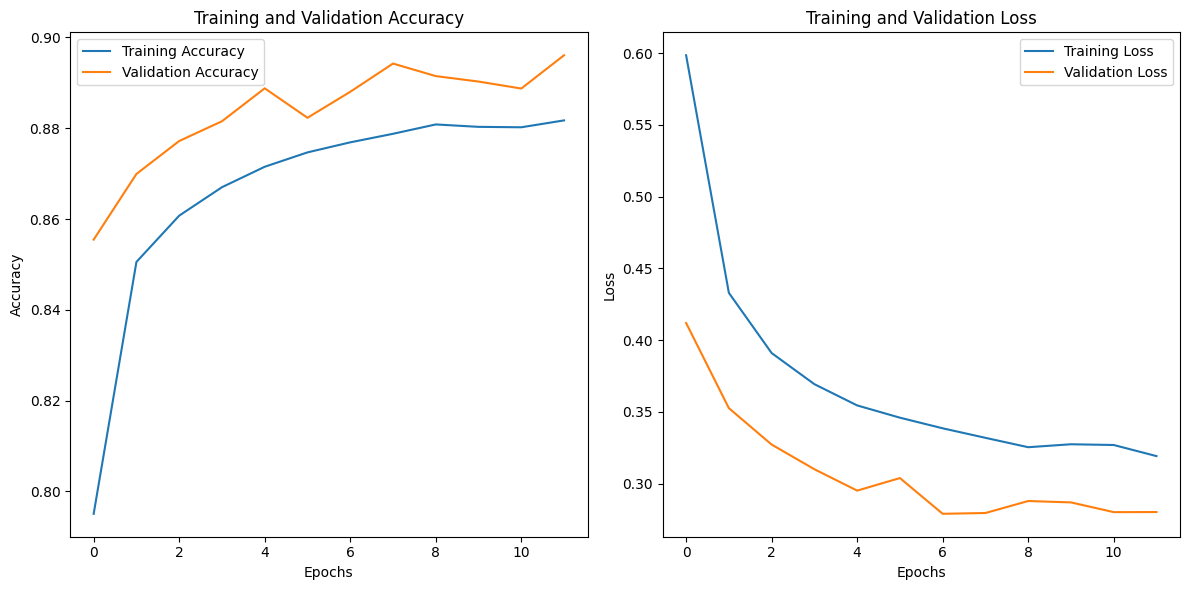

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     12099
           1       0.89      0.95      0.92     14078
           2       0.93      0.61      0.74      3449
           3       0.91      0.86      0.89      5723
           4       0.85      0.87      0.86      4766
           5       0.94      0.57      0.71      1496

    accuracy                           0.89     41611
   macro avg       0.90      0.80      0.84     41611
weighted avg       0.89      0.89      0.88     41611


Metrics:

Train Loss: 0.3191317617893219
Val Loss: 0.28013601899147034
Test Loss: 0.2892597019672394
AUC: 0.9891776138658961
Accuracy: 0.8864723443984985
Precision: 0.888982968725673
Recall: 0.8864723270289107
F1-Score: 0.8824324006423733

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


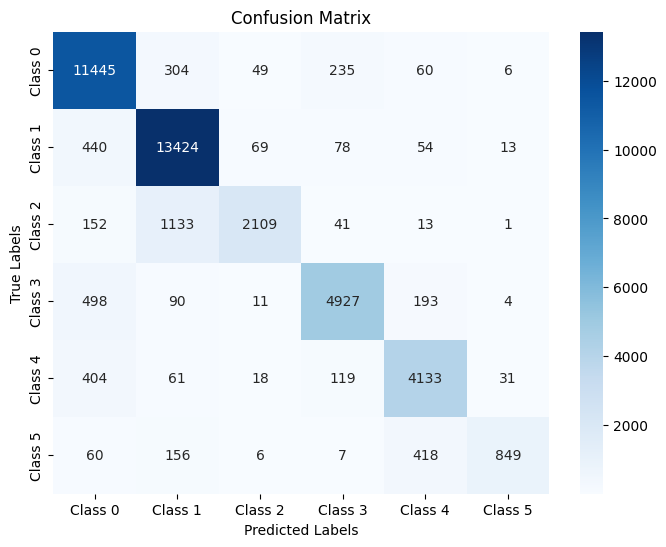


Model saved as 'glove_bilstm_model_4.h5'



In [ ]:
glove_bilstm_model_4, glove_bilstm_metrics_4, glove_bilstm_history_4 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_4.save('glove_bilstm_model_4.h5')
print("\nModel saved as 'glove_bilstm_model_4.h5'\n")

### 5. Batch 16 & LR 0.001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 153s 7ms/step - accuracy: 0.7339 - loss: 0.7191 - val_accuracy: 0.8885 - val_loss: 0.2776
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.8921 - loss: 0.2614 - val_accuracy: 0.9034 - val_loss: 0.2141
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.9050 - loss: 0.2115 - val_accuracy: 0.9113 - val_loss: 0.1936
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.9135 - loss: 0.1859 - val_accuracy: 0.9140 - val_loss: 0.1791
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.9173 - loss: 0.1708 - val_accuracy: 0.9153 - val_loss: 0.1789
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.9204 - loss: 0.1635 - val_accuracy: 0.9181 - val_loss: 0.1708
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 150s 7ms/step - accuracy: 0.9212 - loss: 0.1571 - val_accuracy: 0.9176 - val_loss: 0.1637
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 149s 7ms/s

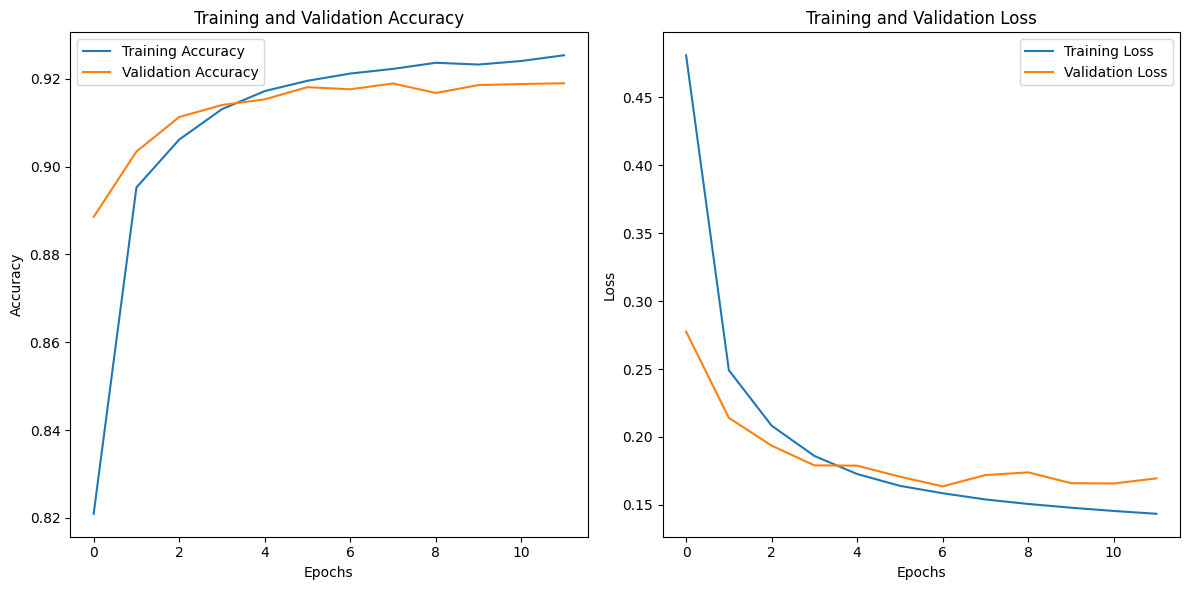

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12099
           1       0.96      0.91      0.93     14078
           2       0.76      0.89      0.82      3449
           3       0.91      0.94      0.93      5723
           4       0.91      0.86      0.89      4766
           5       0.73      0.94      0.82      1496

    accuracy                           0.92     41611
   macro avg       0.87      0.91      0.89     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.14348115026950836
Val Loss: 0.169547900557518
Test Loss: 0.17381036281585693
AUC: 0.9953273357586548
Accuracy: 0.9172093868255615
Precision: 0.9222417168004379
Recall: 0.9172093917473745
F1-Score: 0.9184573031218222

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


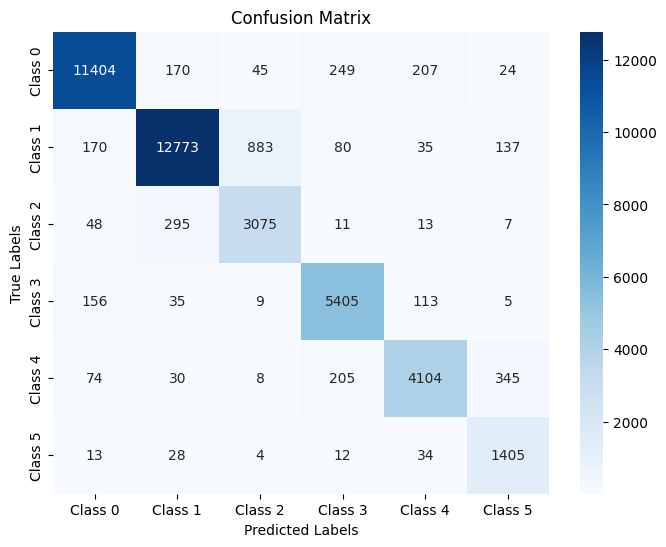


Model saved as 'glove_bilstm_model_5.h5'



In [ ]:
glove_bilstm_model_5, glove_bilstm_metrics_5, glove_bilstm_history_5 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_5.save('glove_bilstm_model_5.h5')
print("\nModel saved as 'glove_bilstm_model_5.h5'\n")

### 6. Batch 16 & LR 0.0001

Epoch 1/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 151s 7ms/step - accuracy: 0.5427 - loss: 1.2173 - val_accuracy: 0.7401 - val_loss: 0.7091
Epoch 2/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.7464 - loss: 0.6956 - val_accuracy: 0.8097 - val_loss: 0.5197
Epoch 3/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8104 - loss: 0.5202 - val_accuracy: 0.8416 - val_loss: 0.4162
Epoch 4/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - accuracy: 0.8418 - loss: 0.4298 - val_accuracy: 0.8629 - val_loss: 0.3523
Epoch 5/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8597 - loss: 0.3758 - val_accuracy: 0.8696 - val_loss: 0.3312
Epoch 6/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - accuracy: 0.8733 - loss: 0.3329 - val_accuracy: 0.8774 - val_loss: 0.3030
Epoch 7/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8807 - loss: 0.3067 - val_accuracy: 0.8793 - val_loss: 0.3019
Epoch 8/100
20805/20805 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/s

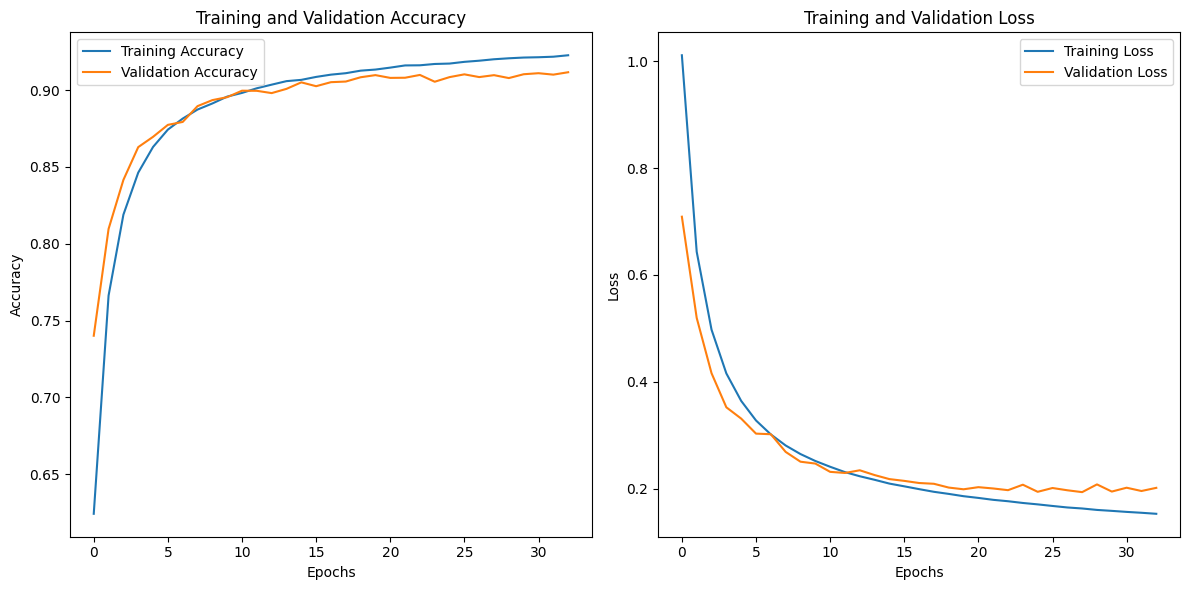

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     12099
           1       0.92      0.93      0.93     14078
           2       0.84      0.74      0.79      3449
           3       0.92      0.91      0.91      5723
           4       0.89      0.87      0.88      4766
           5       0.76      0.81      0.78      1496

    accuracy                           0.91     41611
   macro avg       0.88      0.87      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.15294316411018372
Val Loss: 0.2015119045972824
Test Loss: 0.19708068668842316
AUC: 0.9945450998490933
Accuracy: 0.9089423418045044
Precision: 0.9083278189324533
Recall: 0.9089423469755593
F1-Score: 0.9082908979602411

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


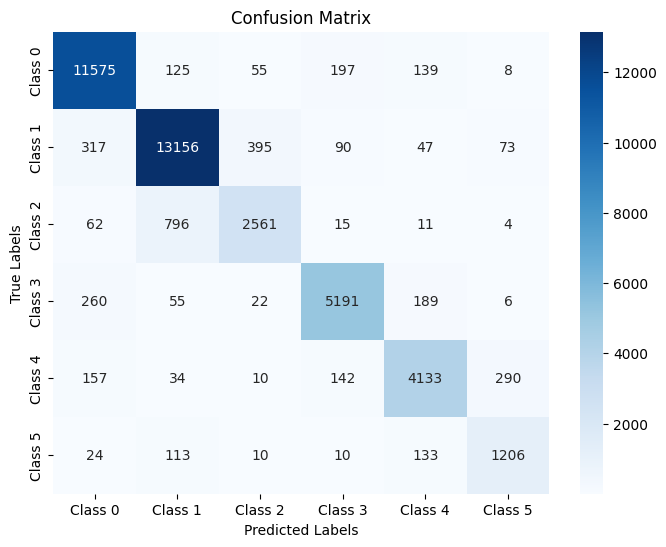


Model saved as 'glove_bilstm_model_6.h5'



In [ ]:
glove_bilstm_model_6, glove_bilstm_metrics_6, glove_bilstm_history_6 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=16,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_6.save('glove_bilstm_model_6.h5')
print("\nModel saved as 'glove_bilstm_model_6.h5'\n")

### 7. Batch 32 & LR 0.01

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.7747 - loss: 0.6327 - val_accuracy: 0.8710 - val_loss: 0.3565
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8729 - loss: 0.3490 - val_accuracy: 0.8892 - val_loss: 0.2817
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8832 - loss: 0.3123 - val_accuracy: 0.8903 - val_loss: 0.2730
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.8891 - loss: 0.2902 - val_accuracy: 0.8959 - val_loss: 0.2605
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8914 - loss: 0.2842 - val_accuracy: 0.8931 - val_loss: 0.2658
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8929 - loss: 0.2740 - val_accuracy: 0.8994 - val_loss: 0.2424
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8959 - loss: 0.2622 - val_accuracy: 0.8984 - val_loss: 0.2435
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - ac

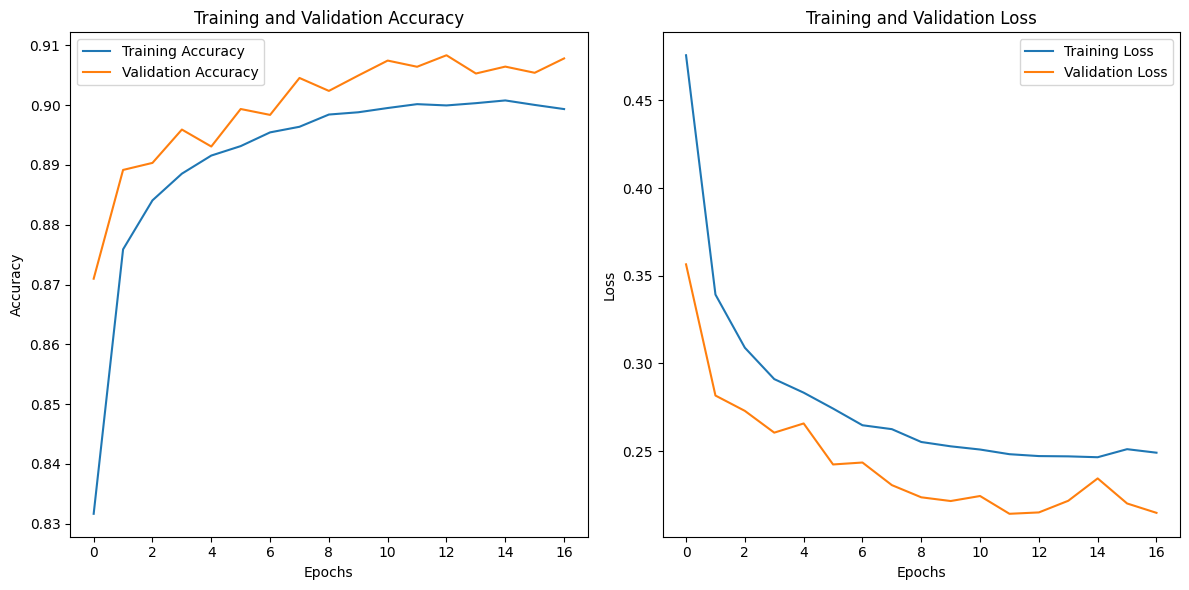

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12099
           1       0.96      0.90      0.93     14078
           2       0.77      0.86      0.81      3449
           3       0.90      0.92      0.91      5723
           4       0.92      0.83      0.87      4766
           5       0.75      0.83      0.79      1496

    accuracy                           0.91     41611
   macro avg       0.87      0.88      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.24910099804401398
Val Loss: 0.21479855477809906
Test Loss: 0.2213830202817917
AUC: 0.9932599173632695
Accuracy: 0.9069236516952515
Precision: 0.9097416591831284
Recall: 0.9069236499963952
F1-Score: 0.9073426988795713

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


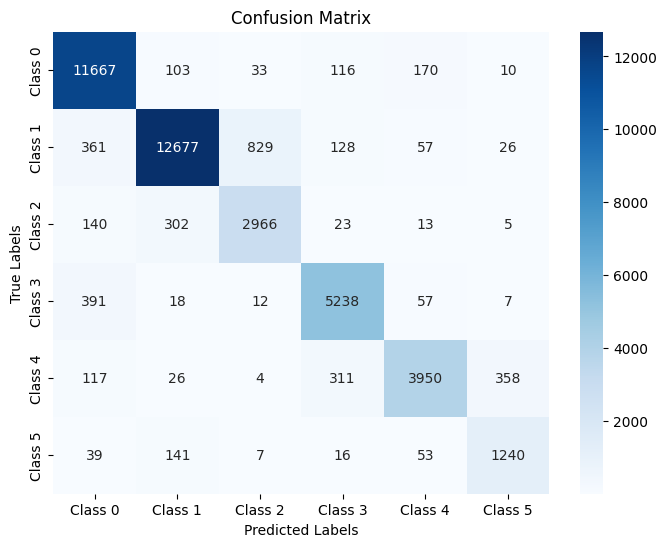


Model saved as 'glove_bilstm_model_7.h5'



In [ ]:
glove_bilstm_model_7, glove_bilstm_metrics_7, glove_bilstm_history_7 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.01,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_7.save('glove_bilstm_model_7.h5')
print("\nModel saved as 'glove_bilstm_model_7.h5'\n")

### 8. Batch 32 & LR 0.001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.7084 - loss: 0.7884 - val_accuracy: 0.8842 - val_loss: 0.2825
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.8853 - loss: 0.2850 - val_accuracy: 0.8957 - val_loss: 0.2411
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9033 - loss: 0.2218 - val_accuracy: 0.9111 - val_loss: 0.1922
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.9117 - loss: 0.1919 - val_accuracy: 0.9116 - val_loss: 0.1823
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - accuracy: 0.9148 - loss: 0.1760 - val_accuracy: 0.9155 - val_loss: 0.1715
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9197 - loss: 0.1640 - val_accuracy: 0.9150 - val_loss: 0.1744
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9217 - loss: 0.1558 - val_accuracy: 0.9185 - val_loss: 0.1633
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - ac

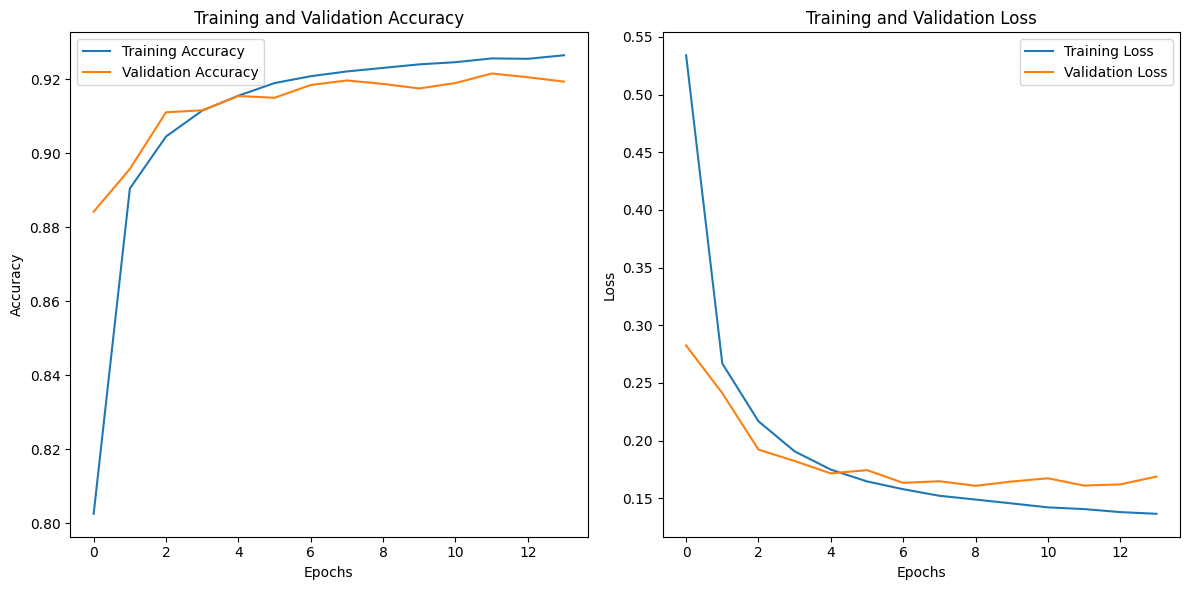

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     12099
           1       0.93      0.94      0.94     14078
           2       0.81      0.81      0.81      3449
           3       0.93      0.92      0.92      5723
           4       0.90      0.86      0.88      4766
           5       0.78      0.81      0.80      1496

    accuracy                           0.92     41611
   macro avg       0.88      0.88      0.88     41611
weighted avg       0.92      0.92      0.92     41611


Metrics:

Train Loss: 0.1365068554878235
Val Loss: 0.16875889897346497
Test Loss: 0.16681751608848572
AUC: 0.9956092496713405
Accuracy: 0.9175698757171631
Precision: 0.9175733362267167
Recall: 0.9175698733507966
F1-Score: 0.9174915897063071

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


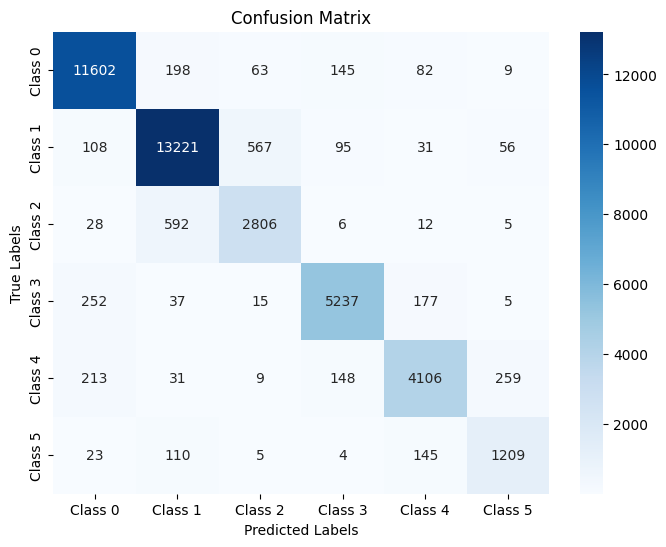


Model saved as 'glove_bilstm_model_8.h5'



In [ ]:
glove_bilstm_model_8, glove_bilstm_metrics_8, glove_bilstm_history_8 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_8.save('glove_bilstm_model_8.h5')
print("\nModel saved as 'glove_bilstm_model_8.h5'\n")

### 9. Batch 32 & LR 0.0001

Epoch 1/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.5222 - loss: 1.2624 - val_accuracy: 0.7037 - val_loss: 0.8055
Epoch 2/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.7127 - loss: 0.7855 - val_accuracy: 0.7814 - val_loss: 0.5971
Epoch 3/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.7818 - loss: 0.6054 - val_accuracy: 0.8154 - val_loss: 0.5051
Epoch 4/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.8181 - loss: 0.5041 - val_accuracy: 0.8370 - val_loss: 0.4351
Epoch 5/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.8413 - loss: 0.4360 - val_accuracy: 0.8554 - val_loss: 0.3761
Epoch 6/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.8560 - loss: 0.3888 - val_accuracy: 0.8654 - val_loss: 0.3476
Epoch 7/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.8645 - loss: 0.3580 - val_accuracy: 0.8757 - val_loss: 0.3172
Epoch 8/100
10403/10403 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - ac

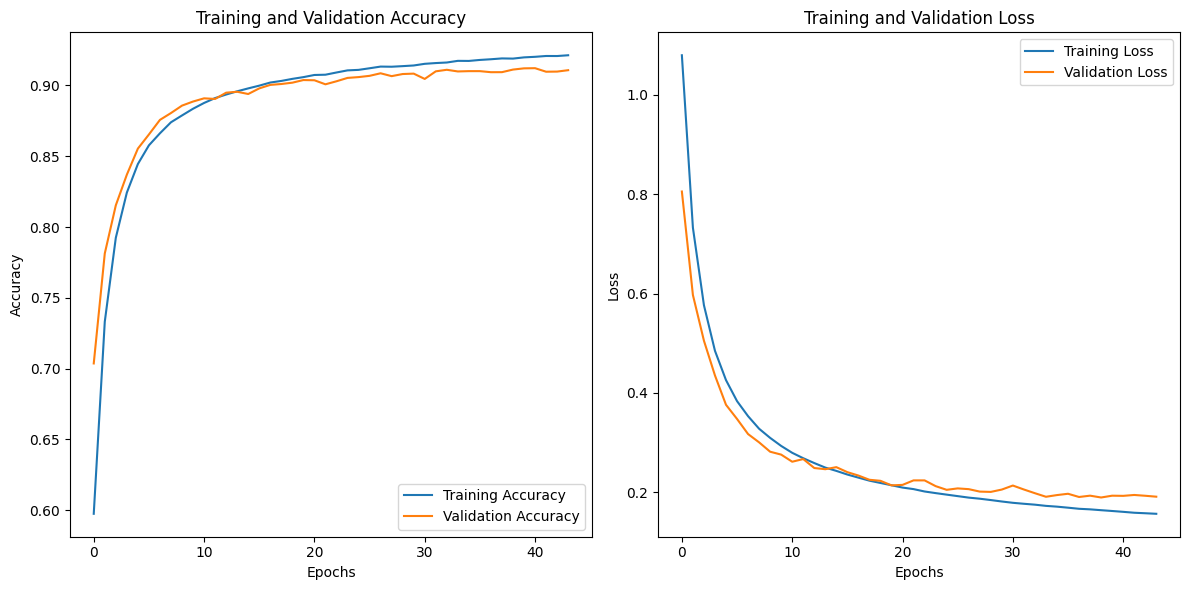

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     12099
           1       0.94      0.91      0.93     14078
           2       0.77      0.85      0.81      3449
           3       0.91      0.93      0.92      5723
           4       0.88      0.86      0.87      4766
           5       0.76      0.81      0.78      1496

    accuracy                           0.91     41611
   macro avg       0.87      0.88      0.87     41611
weighted avg       0.91      0.91      0.91     41611


Metrics:

Train Loss: 0.15665008127689362
Val Loss: 0.1910860389471054
Test Loss: 0.20139522850513458
AUC: 0.9942868543601788
Accuracy: 0.9078608751296997
Precision: 0.9099140349243982
Recall: 0.9078609021652928
F1-Score: 0.9085809221741934

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


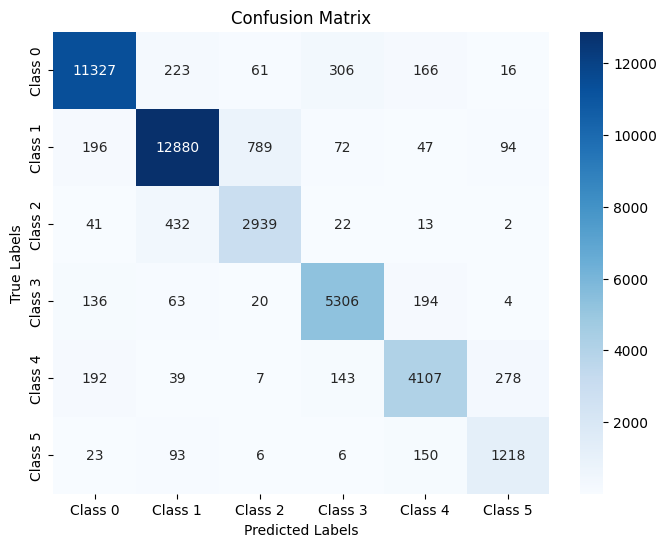


Model saved as 'glove_bilstm_model_9.h5'



In [ ]:
glove_bilstm_model_9, glove_bilstm_metrics_9, glove_bilstm_history_9 = train_and_evaluate(
    input_dim=input_dim,
    batch_size=32,
    learning_rate=0.0001,
    epochs=100,
    X_train=X_train_glove, y_train=train_data['label'],
    X_val=X_val_glove, y_val=val_data['label'],
    X_test=X_test_glove, y_test=test_data['label'],
    model_type="bilstm"
)

glove_bilstm_model_9.save('glove_bilstm_model_9.h5')
print("\nModel saved as 'glove_bilstm_model_9.h5'\n")